# DEMANDA INTERMITENTE

## BLOQUE 0: Preprocesado
### Limpieza y Tratamiento de Datos

In [ ]:
#%pip install pandas
#%pip install matplotlib
#%pip install statsforecast
#%pip install sktime
#%pip install seaborn
#%pip install ace tools
#%pip install pyInterDemand
#%pip install tslearn
#%pip install croston
#%pip install optuna
#%pip install lightgbm
#%pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# ===============================================================
# A. UTILIDADES GENERALES
# ===============================================================
import os, re, csv
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===============================================================
# B. SPLITTING & BACKTESTING (rolling-origin)
# ===============================================================
# # SKTime
# from sktime.split import temporal_train_test_split
# from sktime.split import ExpandingWindowSplitter

# # pyInterDemand
# from pyInterDemand.algorithm.intermittent import classification    # Cálculo de ADI / CV2

#### 1. Carga de datasets

- df_Noel: se carga desde un archivo .xlsx. Por defecto toma los nombres de columa desde el Excel.
- df_Varma: es un CSV sin cabecera (header = None), así que se le asignan los nombres manualmente ('ds', 'y', 'unique_id').
     - skiprows = 1: salta la primera fila (posiblemente una cabecera dañada o innecesaria).
     - quoting = csv.QUOTE_NONE: evita problemas si hay comillas mal puestas.
     - engine = 'python': se usa por compatibilidad al evitar el engine por defecto de C.

In [2]:
# Cargar datasets
df_Noel = pd.read_excel('Noel_Test.xlsx')
df_Varma = pd.read_csv('Varma.csv', sep = ',', header = None, skiprows = 1,
                       names = ['ds', 'y', 'unique_id'],
                       quoting = csv.QUOTE_NONE, engine = 'python')

# df_Noel viene de un Excel con columnas tipo 'PRODUCT_CODE', 'CODE_MONTH', 'TOTAL_AMOUNT'.
# df_Varma viene de un CSV sin cabecera (por eso header = None) con 3 columnas: fecha, demanda e ID.

#### 2. Limpieza de comillas (CSV)

- Se eliminan comillas dobles (") que probablemente vienen mal en el CSV. Evita errores al convertir fechas o IDs.

In [3]:
# Limpieza de comillas en df_Varma
df_Varma['ds']        = df_Varma['ds'].str.strip('"')
df_Varma['unique_id'] = df_Varma['unique_id'].str.strip('"')

#### 3. Conversión de tipos en df_Varma

- Convierte ds a datetime con formato YYYYMM.
- Convierte y a numérico (float), y reemplaza errores con 0. Esto puede enmascarar datos mal cargados: convendría guardar un log de qué valores fueron forzados a 0.

In [4]:
# Conversión de tipos
df_Varma['ds'] = pd.to_datetime(df_Varma['ds'], format = '%Y%m')    # datetime64[ns]
df_Varma['y']  = pd.to_numeric(df_Varma['y'],   errors = 'coerce').fillna(0)  # float

# Se convierte las fechas correctamente.
# Cualquier valor no convertible a numérico en 'y' se transforma en 0. Está bien pero cuidado!!

#### 4. Preparación de df_Noel

- Convierte CODE_MONTH (por ejemplo, 202204) a datetime.
- Renombra columnas para que ambas tablas coincidan con el estándar: 'unique_id', 'ds', 'y'.
- Asegura tipos adecuados (object para IDs y float64 para demanda)
- Elimina la columna original CODE_MONTH.

In [5]:
# Convertir columnas 'PRODUCT_CODE', 'CODE_MONTH' y 'TOTAL_AMOUNT':
df_Noel['ds'] = pd.to_datetime(df_Noel['CODE_MONTH'].astype(str), format = '%Y%m')

df_Noel = df_Noel.rename(columns = {'PRODUCT_CODE': 'unique_id', 'TOTAL_AMOUNT': 'y'})

In [6]:
# Cambiar el tipo de dato de 'unique_id' a objeto (object)
df_Noel['unique_id'] = df_Noel['unique_id'].astype('object')

# Cambiar el tipo de 'y' a float64
df_Noel['y'] = df_Noel['y'].astype('float64')

# Eliminar la columna 'CODE_MONTH'
df_Noel = df_Noel.drop(columns = ['CODE_MONTH'])

#### 5. Reordenación de columnas y filas

- Reorganiza columnas en orden estándar (unique_id, ds, y).
- Ordena cronológicamente cada serie por ID.

In [7]:
# Reordenación de las columnas de los dataframes
df_Noel = df_Noel[['unique_id', 'ds', 'y']]
df_Varma = df_Varma[['unique_id', 'ds', 'y']]

# Ordenar filas ascedentemente primero por 'ds' y luego por 'unique_id'
df_Noel = df_Noel.sort_values(by = ['unique_id', 'ds']).reset_index(drop = True)
df_Varma = df_Varma.sort_values(by = ['unique_id', 'ds']).reset_index(drop = True)

# Se pone las columnas en orden estándar y se ordena cronológicamente cada serie por su unique_id.

#### Resumen general del paso

- Este código deja **dos datasets listos para análisis** de series temporales:
     - Ambos tienen estructura uniforme (unique_id, ds, y).
     - Las fechas están normalizadas.
     - Las IDs están limpias.
     - Las demandas son floats, sin valores nulos (aunque los errores fueron reemplazados por 0 directamente).

## BLOQUE 1: RESUMEN ESTADÍSTICO

### Resumen, Exploración y Tratamiento

Este bloque de código tiene **dos funciones clave** para preparar las series temporales antes de analizarlas o clasificarlas como intermitentes.

#### 6. Parte 1 (summarize_ts(df))

El objetivo es generar un **resumen exploratorio** de un dataset de series temporales:
- Estadísticas globales de la demanda (y).
- Resumen por serie (unique_id): longitud, fechas, valores.

In [8]:
def summarize_ts(df, ds_col = 'ds', id_col = 'unique_id', target_col = 'y'):
    # Asegurarse de que ds es datetime
    df[ds_col] = pd.to_datetime(df[ds_col])

    # 1) Estadísticas descriptivas globales para la columna target_col
    desc_global = df[target_col].describe() # Calcula count, mean, std, min, 25%, 50%, 75%, max.
                                            # Esto ayuda a entender la distribución general de la demanda.

    # 2) Número de series diferentes
    n_series = df[id_col].nunique()

    # 3) Fechas globales (da las fechas mínima y máxima del dataset)
    ds_min_global = df[ds_col].min()
    ds_max_global = df[ds_col].max()

    # 4) Estadísticas por serie usando Named Aggregation
    series_summary = (df.groupby(id_col)
                        .agg(series_length = (target_col, 'size'),
                             mean          = (target_col, 'mean'),
                             median        = (target_col, 'median'),
                             minimum       = (target_col, 'min'),
                             q25           = (target_col, lambda x: x.quantile(0.25)),
                             q75           = (target_col, lambda x: x.quantile(0.75)),
                             maximum       = (target_col, 'max'),
                             first_date    = (ds_col, 'min'),
                             last_date     = (ds_col, 'max'))
                        .reset_index()
                        # opcional: ordenar columnas
                        [['unique_id', 'series_length', 'first_date', 'last_date', 'mean', 'median', 'minimum', 'q25', 'q75', 'maximum']])

    # Imprimir resumen global
    print("=== Estadísticas globales de", target_col, "===")
    print(desc_global.to_frame().T, end = "\n\n")
    print(f"Número de series ({id_col} distintos): {n_series}")
    print(f"Fecha mínima global ({ds_col}): {ds_min_global.date()}")
    print(f"Fecha máxima global ({ds_col}): {ds_max_global.date()}", end = "\n\n")

    print("=== Estadísticas por serie ===")
    display(series_summary) # en Jupyter; en script podría ser print(series_summary)

    # Devolver para uso programático
    return {'global_stats':   desc_global,
            'n_series':       n_series,
            'ds_min_global':  ds_min_global,
            'ds_max_global':  ds_max_global,
            'series_summary': series_summary}

**Valor agregado**

Esta función permite:
- Verificar si las series son de longitud comparable.
- Detectar outliers.
- Confirmar si hay series con pocos datos o con fechas recortadas.

In [9]:
# Utilización de la función summarize_ts
summary_Noel  = summarize_ts(df_Noel)
summary_Varma = summarize_ts(df_Varma)

=== Estadísticas globales de y ===
    count         mean           std  min    25%     50%      75%       max
y  3389.0  13765.90675  28856.218909  0.0  570.0  3328.0  12672.0  295800.0

Número de series (unique_id distintos): 326
Fecha mínima global (ds): 2019-01-01
Fecha máxima global (ds): 2025-04-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,12193,47,2019-01-01,2025-03-01,17412.852553,16943.36,8906.55,16515.62,17388.80,34481.200
1,12235,37,2019-01-01,2025-04-01,48.358649,31.73,3.92,5.19,42.00,382.060
2,12383,9,2019-04-01,2024-08-01,268.277111,157.16,59.57,90.42,297.79,864.864
3,12613,14,2019-02-01,2024-08-01,2303.982143,203.00,84.00,203.00,1921.25,10552.500
4,12806,17,2020-04-01,2025-04-01,20653.176471,11648.00,6656.00,9984.00,29952.00,59904.000
...,...,...,...,...,...,...,...,...,...,...
321,41142,5,2024-08-01,2024-12-01,57.600000,56.00,40.00,48.00,64.00,80.000
322,41143,5,2024-08-01,2024-12-01,58.400000,64.00,32.00,48.00,68.00,80.000
323,41144,5,2024-08-01,2024-12-01,60.000000,56.00,48.00,52.00,64.00,80.000
324,41150,3,2024-11-01,2025-01-01,705.666667,242.00,184.00,213.00,966.50,1691.000


=== Estadísticas globales de y ===
    count        mean          std     min  25%  50%   75%      max
y  2201.0  260.447751  3184.908318 -1350.0  1.0  6.0  30.0  96000.0

Número de series (unique_id distintos): 365
Fecha mínima global (ds): 2023-01-01
Fecha máxima global (ds): 2025-06-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,0102300062,12,2023-01-01,2025-05-01,14.333333,8.5,1.0,3.00,30.00,30.0
1,0102300068,7,2024-06-01,2025-04-01,59.000000,54.0,18.0,39.00,84.50,94.0
2,0102300535,12,2023-03-01,2025-04-01,39.833333,36.0,2.0,16.50,55.75,96.0
3,0102300537,6,2024-08-01,2025-05-01,78.000000,57.0,12.0,24.00,126.00,180.0
4,0102300548,3,2024-09-01,2025-05-01,400.000000,480.0,120.0,300.00,540.00,600.0
...,...,...,...,...,...,...,...,...,...,...
360,0518001050,1,2024-12-01,2024-12-01,509.000000,509.0,509.0,509.00,509.00,509.0
361,0520400026,5,2024-09-01,2025-05-01,4.200000,2.0,0.0,1.00,4.00,14.0
362,0520400027,6,2024-10-01,2025-05-01,4.833333,4.5,0.0,2.25,7.50,10.0
363,0520400030,6,2024-09-01,2025-05-01,1.833333,1.5,0.0,0.25,2.00,6.0


#### 7. Parte 2 (fill_missing_months(df))

El objetivo es **rellenar las fechas faltantes** de cada serie para que sean mensualmente continuas hasta la fecha máxima global, imputando 0.0 en los valores ausentes.
Esto es crítico para demanda intermitente. Si no se hace, métricas como el ADI y el CV² quedan sesgadas, porque ignoran los ceros.

---
Ahora se procede a rellenar las series de ambos DataFrames con registros virtuales con demanda igual a cero (y = 0) para aquellas fechas (filas) que faltan, de manera que así, cada serie (unique_id), tenga registros periódicos desde la fecha inicial de cada serie, aunque sea demanda cero o nula.

También se añade registros con demanda cero a todas aquellas series cuya fecha final sea inferior a la fecha final global del dataset, de manera que todas las series acaben en el mismo instante de tiempo, independientemente de su fecha de inicio.

---

In [10]:
# 1. Calcula la fecha máxima global en ds.
# 2. Para cada unique_id, genera todas las fechas mensuales desde su fecha mínima hasta esa fecha global.
# 3. Rellena los valores faltantes de 'y' con 0.0
# 4. Devuelve un DataFrame ordenado por 'unique_id' y luego por 'ds'.

# Esta función garatniza que cada serie temporal esté completamente definida desde su inicio 
# hasta el último mes global del dataset, rellenando los meses faltantes con ceros.

def fill_missing_months(df, ds_col = 'ds', id_col = 'unique_id', target_col = 'y'):
    # Copia y asegura tipos
    df = df.copy()
    df[ds_col] = pd.to_datetime(df[ds_col])
    df[id_col] = df[id_col].astype('object')
    df[target_col] = df[target_col].astype('float64')

    # Fecha Global Máxima
    global_max_date = df[ds_col].max()

    filled = []
    # Iteramos por serie
    for uid, grp in df.groupby(id_col, sort = False):
        # Para cada serie (producto):
        # Se toma el primer mes registrado (start)
        # Se crea un rango mensual completo desde start hasta global_max_date.
        start = grp[ds_col].min()
        # Generar rango mensual desde el inicio de la serie hasta global_max
        all_months = pd.date_range(start = start, end = global_max_date, freq = 'MS')

        # DataFrame base con todas las fechas
        tmp = pd.DataFrame({ds_col: all_months})
        tmp[id_col] = uid

        # Merge para traer los 'y' originales (si existen)
        tmp = tmp.merge(grp[[ds_col, target_col]], on = ds_col, how = 'left')

        # Imputar NaN con 0.0
        tmp[target_col] = tmp[target_col].fillna(0.0)

        filled.append(tmp)
    
    # Concatenar todo
    df_filled = pd.concat(filled, ignore_index = True)

    # Renombrar columnas y filas
    df_filled = df_filled[[id_col, ds_col, target_col]]
    df_filled = (df_filled.sort_values(by = [id_col, ds_col]).reset_index(drop = True))

    # Asegurar tipos finales
    df_filled[id_col] = df_filled[id_col].astype('object')
    df_filled[target_col] = df_filled[target_col].astype('float64')

    return df_filled

# Esto es importnate porque si no se hace, el cálculo de ADI (Average Demand Interval) y
# CV^2 se sesga, ya que omite meses con demanda cero no registrada.
# Y eso haría clasificar mal las series. (PROCESO DE REPARACIÓN DE SERIES DISCONTINUAS)

In [11]:
# Uso de la función fill_missing_months
df_Noel_filled  = fill_missing_months(df_Noel)
df_Varma_filled = fill_missing_months(df_Varma)

# Verificar
print(df_Noel_filled.head())
print(df_Noel_filled.dtypes)

print(df_Varma_filled.head())
print(df_Varma_filled.dtypes)

  unique_id         ds         y
0     12193 2019-01-01  17148.81
1     12193 2019-02-01  18449.09
2     12193 2019-03-01  16504.88
3     12193 2019-04-01  16862.63
4     12193 2019-05-01      0.00
unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object
    unique_id         ds    y
0  0102300062 2023-01-01  3.0
1  0102300062 2023-02-01  1.0
2  0102300062 2023-03-01  3.0
3  0102300062 2023-04-01  0.0
4  0102300062 2023-05-01  3.0
unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object


**Valor agregado**

Este paso es **indispensable para**:
- Evitar que el modelo interprete mal la **intermitencia**.
- Usar bien modelos y métricas como Croston, ADI, CV², etc.
- Hacer que el horizonte temporal de cada serie sea coherente con las demás.

**Conclusión del bloque**
- `summarize_ts` da una **visión exploratoria** clara del dataset.
- `fill_missing_months` **repara las series** para que estén listas para análisis intermitente o entrenamiento robusto.

---
Como se ve en los resultados, las columnas de ambos sets son: 'unique_id', 'ds', 'y'; y sus respectivos tipos de datos son: object, datetime64[ns] y float64.

---

#### 8. Imputación de valores negativos

Este paso asegura que **no existan valores negativos de demanda**.

Esto tiene sentido en escenarios donde:
- **No hay devoluciones o ajustes negativos**.
- Todo valor negativo es considerado **error o dato mal cargado**.

In [12]:
# Imputación de valores negativos a cero
# Para df_Noel_filled y df_Varma_filled, antes de caracterizar:
for df in (df_Noel_filled, df_Varma_filled):
    # Opción A: usando clip
    df['y'] = df['y'].clip(lower = 0.0)

    # Opción B: usando loc
    # df.loc[df['y'] < 0, 'y'] = 0.0

# Con esto, cualquier y < 0 pasará a valer 0.0 y el describe() nunca 
# mostrará medias negativas ni mínimos por debajo de cero.
# Se hace con la premisa de que en este escenario no existe lógica 
# de devoluciones o ajustes negativos de stock.

#### 9. Comprobación de Imputación

- Reutiliza la función `summarize_ts()` ya explicada.
- Permite verificar que ya no hay valores negativos y que las estadísticas tienen sentido.
- Confirmación de integridad del número de series tras la imputación y relleno.

In [13]:
# Uso de la función summarize_ts a modo de comprobación tras la imputación
summary_Noel_filled  = summarize_ts(df_Noel_filled)
summary_Varma_filled = summarize_ts(df_Varma_filled)

=== Estadísticas globales de y ===
     count         mean           std  min  25%  50%        75%       max
y  12323.0  3785.819847  16332.057029  0.0  0.0  0.0  66.132044  295800.0

Número de series (unique_id distintos): 326
Fecha mínima global (ds): 2019-01-01
Fecha máxima global (ds): 2025-04-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,12193,76,2019-01-01,2025-04-01,10768.474605,16364.07,0.0,0.0,17126.8125,34481.200
1,12235,76,2019-01-01,2025-04-01,23.543026,0.00,0.0,0.0,27.6200,382.060
2,12383,73,2019-04-01,2025-04-01,33.075260,0.00,0.0,0.0,0.0000,864.864
3,12613,75,2019-02-01,2025-04-01,430.076667,0.00,0.0,0.0,0.0000,10552.500
4,12806,61,2020-04-01,2025-04-01,5755.803279,0.00,0.0,0.0,6656.0000,59904.000
...,...,...,...,...,...,...,...,...,...,...
321,41142,9,2024-08-01,2025-04-01,32.000000,40.00,0.0,0.0,56.0000,80.000
322,41143,9,2024-08-01,2025-04-01,32.444444,32.00,0.0,0.0,64.0000,80.000
323,41144,9,2024-08-01,2025-04-01,33.333333,48.00,0.0,0.0,56.0000,80.000
324,41150,6,2024-11-01,2025-04-01,352.833333,92.00,0.0,0.0,227.5000,1691.000


=== Estadísticas globales de y ===
    count      mean          std  min  25%  50%  75%      max
y  7260.0  79.20466  1757.352604  0.0  0.0  0.0  0.0  96000.0

Número de series (unique_id distintos): 365
Fecha mínima global (ds): 2023-01-01
Fecha máxima global (ds): 2025-06-01

=== Estadísticas por serie ===


,unique_id,series_length,first_date,last_date,mean,median,minimum,q25,q75,maximum
0,0102300062,30,2023-01-01,2025-06-01,5.733333,0.0,0.0,0.0,3.00,30.0
1,0102300068,13,2024-06-01,2025-06-01,31.769231,18.0,0.0,0.0,54.00,94.0
2,0102300535,28,2023-03-01,2025-06-01,17.071429,0.0,0.0,0.0,27.00,96.0
3,0102300537,11,2024-08-01,2025-06-01,42.545455,12.0,0.0,0.0,57.00,180.0
4,0102300548,10,2024-09-01,2025-06-01,120.000000,0.0,0.0,0.0,90.00,600.0
...,...,...,...,...,...,...,...,...,...,...
360,0518001050,7,2024-12-01,2025-06-01,72.714286,0.0,0.0,0.0,0.00,509.0
361,0520400026,10,2024-09-01,2025-06-01,2.100000,0.0,0.0,0.0,1.75,14.0
362,0520400027,9,2024-10-01,2025-06-01,3.222222,2.0,0.0,0.0,6.00,10.0
363,0520400030,10,2024-09-01,2025-06-01,1.100000,0.0,0.0,0.0,1.75,6.0


In [14]:
# A modo de verificación, se imprime el número de series únicas por DataFrame:
print(df_Noel_filled['unique_id'].nunique())  # → debería imprimir 326
print(df_Varma_filled['unique_id'].nunique()) # → debería imprimir 365

326
365


## BLOQUE 2: CARACTERIZACIÓN DE LAS SERIES

### Definición de Métricas Clave

#### 10. ADI - Average Demand Interval
- Se interpreta como la cantidad **promedio de períodos entre demandas positivas**.
- Cuanto **más alta**, más **intermitente** es la serie.
- Si **nunca hay demanda**, se devuelve `inf`.

In [15]:
# Definimos ADI y CV2
def calculate_adi(ts: pd.Series) -> float:
    n_tot = len(ts)
    n_nonzero = (ts > 0).sum()
    return n_tot / n_nonzero if n_nonzero > 0 else np.inf

# ADI = total_periodos / número_periodos_con_demanda
# Si nunca hay demanda: ADI = infinito -> Comportamiento constante nulo.

#### 11. CV² - Squared Coefficient of Variation
- Mide la **variabilidad relativa** de la demanda positiva.
- Cuanto mayor es el **CV²**, más **errática** es la serie.
- Solo se calcula sobre valores positivos (es lo correcto).

In [16]:
def calculate_cv2(ts: pd.Series) -> float:
    v = ts[ts > 0]
    mu = v.mean()
    sigma = v.std(ddof = 0) # poblacional
    return (sigma / mu)**2 if mu != 0 else np.nan

# CV^2 = (Desviación estándar / media)^2
# Se calcula solo con valores positivos.
# Cuanto mayor es CV^2, más variable es la serie.

#### 12. Caracterización y Clasificación de Series

Esta función recorre cada serie individualmente y calcula:
- **Estadísticas agregadas**: media, percentiles, min, max, etc.
- **Proporción de ceros**.
- **ADI y CV²**.
- **Clasificación tipológica** de la serie.

La Clasificación basada en Syntetos & Boylan (2005) tiene una lógica de agrupación de series tal que:
- **Smooth**: Baja Intermitencia y Baja Variabilidad.
- **Erratic**: Baja Intermitencia y Alta Variabilidad.
- **Intermittent**: Alta Intermitencia y Baja Variabilidad.
- **Lumpy**: Alta Intermitencia y Alta Variabilidad.

Lo umbrales clásicos usados en literatura son:
- `ADI` umbral ≈ 1.32 (valores > 1.32 indican intermitencia).
- `CV²` umbral ≈ 0.49 (valores > 0.49 indican alta variabilidad).

**SUGERENCIA**
1. Visualizar resultados:
     - Histograma de ADI y CV2.
     - Conteo de categorías (df['Cat'].value_counts()).
     - Graficar ejemplos por clase.

In [17]:
# Nueva versión de characterize_series usando esas funciones
# Recorre cada unique_id, extrae su serie temporal ordenada y calcula:
# - Estadísticas:
# - Clasificación según reglas de Syntetos & Boylan (2005) (ADI/CV^2)
def characterize_series(df, ds_col: str = 'ds', 
                            id_col: str = 'unique_id', 
                            y_col:  str = 'y') -> pd.DataFrame:
    
    # ¿Cuántas series tenemos?
    unique_ids = df[id_col].unique()
    print(f"✔️ Encontradas {len(unique_ids)} series distintas (IDs).")

    records = []
    for uid in unique_ids:
        grp = df[df[id_col] == uid]
        ts  = grp.set_index(ds_col)[y_col].sort_index()

        # ADI y CV²
        adi = calculate_adi(ts)
        cv2 = calculate_cv2(ts)

        # Estadísticas descriptivas de y
        desc = ts.describe()  # count, mean, std, min, 25%, 50%, 75%, max

        # Proporción de ceros
        pz = (ts == 0).mean()

        # Categoría final (mismo criterio interno)
        if   (adi >= 1.32 and cv2 <= 0.49): cat = 'Intermittent'
        elif (adi >= 1.32 and cv2 >= 0.49): cat = 'Lumpy'
        elif (adi <= 1.32 and cv2 >= 0.49): cat = 'Erratic'
        else:                               cat = 'Smooth'
        

        # No se incluye explícitamente la categoría 'Continuous', 
        # pero como estamos trabajando con series intermitentes, todas tendrán algún cero.

        records.append({id_col       : uid,
                        'mean'       : desc['mean'],
                        'std'        : desc['std'],
                        'min'        : desc['min'],
                        '25%'        : desc['25%'],
                        'median'     : desc['50%'],
                        '75%'        : desc['75%'],
                        'max'        : desc['max'],
                        'first_date' : ts.index.min(),
                        'last_date'  : ts.index.max(),
                        'length'     : len(ts),
                        'pZeros'     : pz,
                        'ADI'        : adi,
                        'CV2'        : cv2,
                        'Cat'        : cat})

    summary_df = pd.DataFrame.from_records(records)

    # Asegúrate del orden de columnas
    cols = [id_col, 'mean', 'std', 'min', '25%', 'median', '75%', 'max', 'first_date', 'last_date', 'length', 'pZeros', 'ADI', 'CV2', 'Cat']
    return summary_df.loc[:, cols].reset_index(drop = True)
    #      ^-----------------seleccionamos "todas las filas" y luego las columnas cols

    # Con esto se tiene un dataframe de series caracterizadas, donde cada fila representa un producto 
    # (unique_id) y contiene:
    # - Sus estadísticas agregadas.
    # - Su nivel de intermitencia.
    # - Su categoría (Smooth, Erratic, Intermittent, Lumpy)
    # Esto es clave para los pasos siguientes: dividir por tipo de serie y horizonte posible, y luego
    # aplicar modelos adaptados a cada grupo.

### Visualización de la dispersión de las series

Esta sección representa la **fase de analísis exploratorio final y visualización** del perfil de demanda, posterior a la caracterización por `ADI` y `CV²`.

Incluye funciones para:
- Visualizar la dispersión de series según su comportamiento.
- Construir tablas resumen por tipo de serie.
- Convertir el dataset a formato 'wide' para modelado.

#### 13 plot_demand_by_category(summary_df)

El objetivo es visualizar cada serie como un punto en el espacio `CV² vs ADI`, coloreado por su categoría (Smooth, Intermittent, Erratic, Lumpy).

In [18]:
# Función para dibujar el scatter plot
def plot_demand_by_category(summary_df):
    # Definimos mapeo categoría → (sigla, color)
    cat_map = {'Intermittent': ('ITS', 'C0'),
               'Smooth':       ('STS', 'C1'),
               'Erratic':      ('ETS', 'C2'),
               'Lumpy':        ('LTS', 'C3')}

    fig, ax = plt.subplots(figsize = (10, 8))

    # Scatter por categoría
    for cat, (abbr, color) in cat_map.items():
        df_cat = summary_df[summary_df['Cat'] == cat]
        ax.scatter(df_cat['CV2'], df_cat['ADI'], label = f"{abbr} ({len(df_cat)})", alpha = 0.6, color = color)
        # Se dibujan los puntos de cada categoría por separado.
        # El label incluye el código abreviado y la cantidad de series (len(df_cat))

    # Líneas de corte (Umbrales)
    ax.axvline(x = 0.49, color = 'red', linewidth = 1.2)
    # Frontera entre Smooth/Erratic e Intermittent/Lumpy.
    ax.axhline(y = 1.32, color = 'red', linewidth = 1.2)
    # Frontera entre low ADI y high ADI.

    ax.set_xlabel('CV² (Variabilidad Relativa)')
    ax.set_ylabel('ADI (Intermitencia Promedio)')
    ax.set_title('Perfil de Demanda: CV² vs ADI')
    # ax.set_xlim(left   = -0.1)
    # ax.set_ylim(bottom = -0.1)

    ax.legend(title = 'Categoría (n° series)')
    plt.grid(alpha  = 0.3)
    plt.tight_layout()
    plt.show()

**Valor agregado**

- Permite *ver* claramente las regiones de comportamiento de demanda.
- Muy útil para verificar que la clasificación no sea arbitraria y esté distribuida con sentido.
- Identificas zonas vacías (ej., ¿hay muchas Smooth o dominan las Lumpy?)

#### 14. category_summary_table(summary_df)

El objetivo es crear una tabla resumen de las categorías, con:
- Número de series (`count`)
- Porcentaje (`percent`)
- Sigla (`abbr`)

In [19]:
# Tabla resumen de la clasificación y composición de lo datasets
def category_summary_table(summary_df):
    # Conteo y porcentaje por categoría
    vc = summary_df['Cat'].value_counts().rename('count')
    pct = (vc / vc.sum() * 100).round(1).rename('percent')
    # Calcula conteo absoluto y relativo.

    table = pd.concat([vc, pct], axis = 1).reset_index()
    table.columns = ['Cat', 'count', 'percent']

    # Añadir columas de sigla (Mapea categorías a siglas útiles para etiquetas o análisis)
    siglas = {'Intermittent':'ITS', 'Smooth':'STS', 'Erratic':'ETS', 'Lumpy':'LTS'}
    table['abbr'] = table['Cat'].map(siglas)

    # Reordenar columnas
    return table[['Cat', 'abbr', 'count', 'percent']]

# Tabla resumen de cuántas series hay por tipo de demanda.
# - Calcula conteo y porcentaje de cada categoría.
# - Añade siglas, útil si se quiere etiquetar gráficos o usar abreviaciones más prácticas.

#### 15. Ejecución: Caracterización + Visualización

- Se ejecuta la caracterización con las funcionesya analizadas.
- Se muestra la tabla y el gráfico para cada dataset.

In [20]:
# Uso de la función characterize_series:
df_Noel_summary  = characterize_series(df_Noel_filled)
df_Varma_summary = characterize_series(df_Varma_filled)

# print("Noel:",  df_Noel_summary.shape,  "→ 326 series filas")
# print("Varma:", df_Varma_summary.shape, "→ 365 series filas")

✔️ Encontradas 326 series distintas (IDs).
✔️ Encontradas 365 series distintas (IDs).


In [21]:
# Graficar la tabla resumen
# Noel
print('Tabla resumen de categorías (Noel):')
print(category_summary_table(df_Noel_summary).to_string(index = False))
print('------------------------------------')
# Varma
print('Tabla resumen de categorías (Varma):')
print(category_summary_table(df_Varma_summary).to_string(index = False))

Tabla resumen de categorías (Noel):
         Cat abbr  count  percent
Intermittent  ITS    273     83.7
       Lumpy  LTS     53     16.3
------------------------------------
Tabla resumen de categorías (Varma):
         Cat abbr  count  percent
       Lumpy  LTS    181     49.6
Intermittent  ITS    177     48.5
      Smooth  STS      7      1.9



Gráfico de demanda por categoría (Noel):


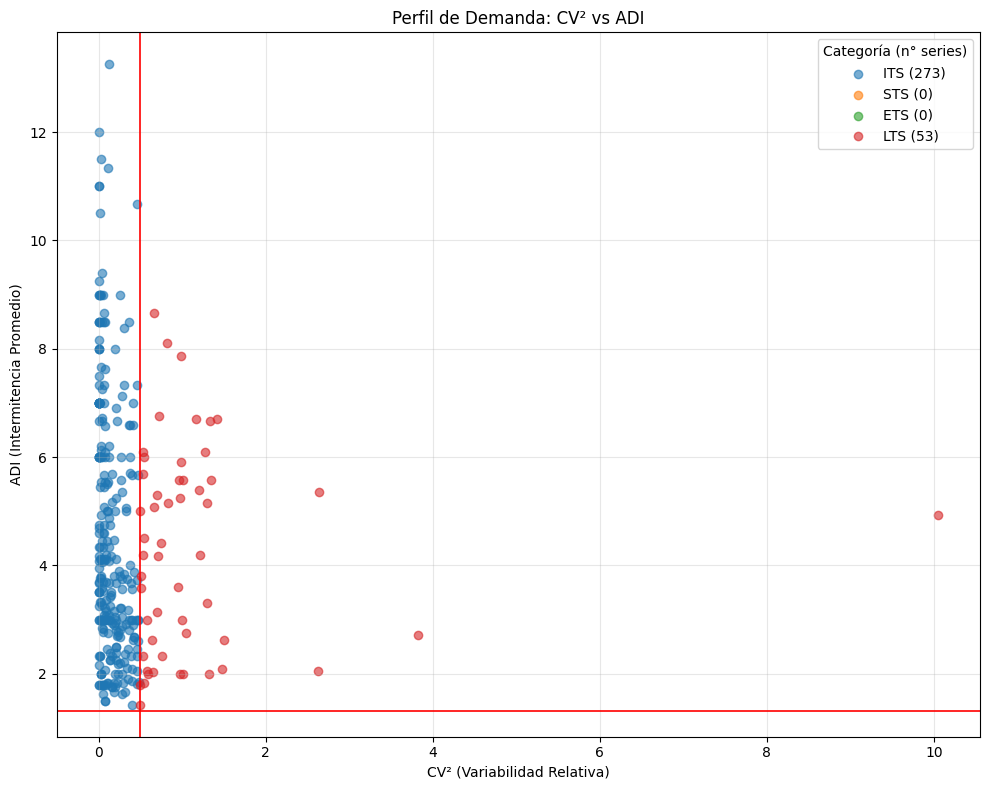


Gráfico de demanda por categoría (Varma):


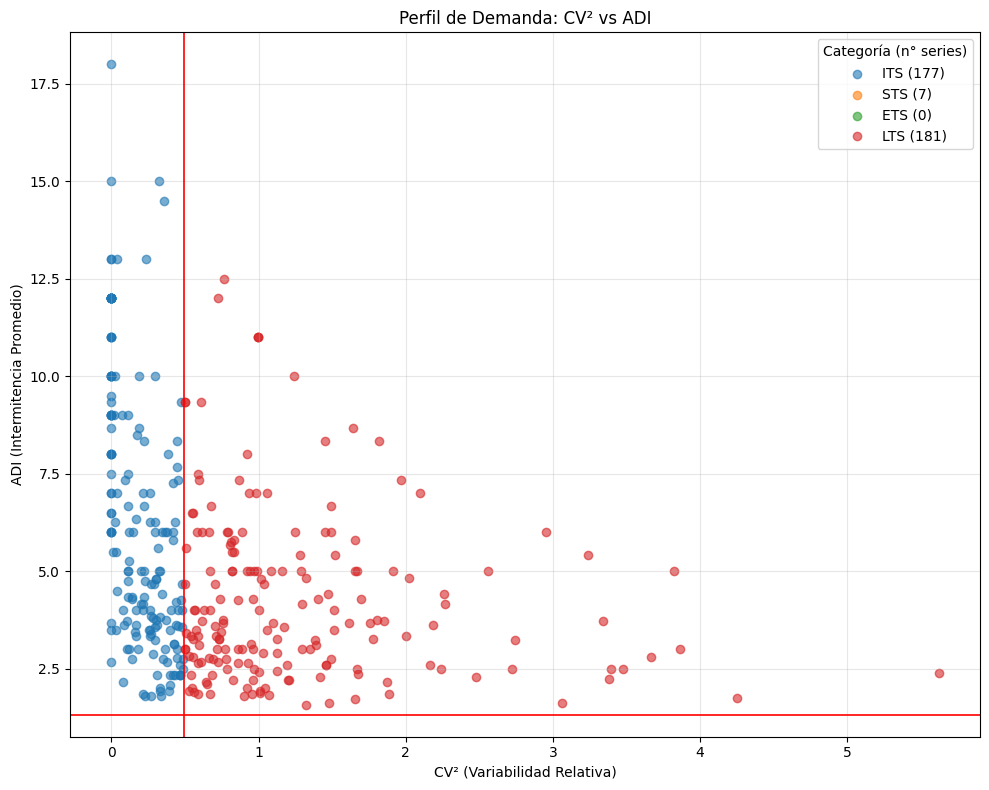

In [22]:
# Dibuja el scatter
# Noel
print("\nGráfico de demanda por categoría (Noel):")
plot_demand_by_category(df_Noel_summary)

# Varma
print("\nGráfico de demanda por categoría (Varma):")
plot_demand_by_category(df_Varma_summary)

---
Ahora se presenta un breve resumen de ambos DataFrames y luego se pivotan las matrices para facilitar el posterior análisis y modelado.

---

In [23]:
# -----------------------------------------------------------
# Ejemplo de uso con tu DataFrame rellenado de Noel:
print("\n→ Resumiendo df_Noel_filled…")
df_Noel_summary = characterize_series(df_Noel_filled)
print("Shape de resumen Noel (filas = series):", df_Noel_summary.shape)
display(df_Noel_summary.head())


→ Resumiendo df_Noel_filled…
✔️ Encontradas 326 series distintas (IDs).
Shape de resumen Noel (filas = series): (326, 15)


,unique_id,mean,std,min,25%,median,75%,max,first_date,last_date,length,pZeros,ADI,CV2,Cat
0,12193,10768.474605,8992.842311,0.0,0.0,16364.07,17126.8125,34481.200,2019-01-01,2025-04-01,76,0.381579,1.617021,0.044037,Intermittent
1,12235,23.543026,60.200086,0.0,0.0,0.00,27.6200,382.060,2019-01-01,2025-04-01,76,0.513158,2.054054,2.628113,Lumpy
2,12383,33.075260,123.402952,0.0,0.0,0.00,0.0000,864.864,2019-04-01,2025-04-01,73,0.876712,8.111111,0.815964,Lumpy
3,12613,430.076667,1861.112132,0.0,0.0,0.00,0.0000,10552.500,2019-02-01,2025-04-01,75,0.813333,5.357143,2.635646,Lumpy
4,12806,5755.803279,12180.865572,0.0,0.0,0.00,6656.0000,59904.000,2020-04-01,2025-04-01,61,0.721311,3.588235,0.506368,Lumpy


In [24]:
# -----------------------------------------------------------
# Ejemplo de uso con tu DataFrame rellenado de Varma:
print("\n→ Resumiendo df_Varma_filled…")
df_Varma_summary = characterize_series(df_Varma_filled)
print("Shape de resumen Varma (filas = series):", df_Varma_summary.shape)
display(df_Varma_summary.head())


→ Resumiendo df_Varma_filled…
✔️ Encontradas 365 series distintas (IDs).
Shape de resumen Varma (filas = series): (365, 15)


,unique_id,mean,std,min,25%,median,75%,max,first_date,last_date,length,pZeros,ADI,CV2,Cat
0,0102300062,5.733333,10.865743,0.0,0.0,0.0,3.0,30.0,2023-01-01,2025-06-01,30,0.600000,2.500000,0.788805,Lumpy
1,0102300068,31.769231,37.013857,0.0,0.0,18.0,54.0,94.0,2024-06-01,2025-06-01,13,0.461538,1.857143,0.213157,Intermittent
2,0102300535,17.071429,28.035597,0.0,0.0,0.0,27.0,96.0,2023-03-01,2025-06-01,28,0.571429,2.333333,0.543145,Lumpy
3,0102300537,42.545455,63.975564,0.0,0.0,12.0,57.0,180.0,2024-08-01,2025-06-01,11,0.454545,1.833333,0.666667,Lumpy
4,0102300548,120.000000,226.274170,0.0,0.0,0.0,90.0,600.0,2024-09-01,2025-06-01,10,0.700000,3.333333,0.260000,Intermittent


#### 16. `pivot` a formato 'wide'

El objetivo de este paso es transformar los datos en matriz temporal. Ideal para:
- Modelos multivariantes(VAR, DeepAR, etc.).
- Visualización de múltiples series con `plot(df)` o `heatmaps`.
- Detección de outliers o análisis de correlación entre productos.

In [25]:
# Pivotado a formato "wide" para facilitar el análisis y modelado
df_Noel_pivoted  =  df_Noel_filled.pivot(index = 'ds', columns = 'unique_id', values = 'y')
df_Varma_pivoted = df_Varma_filled.pivot(index = 'ds', columns = 'unique_id', values = 'y')

# Este pivo crea una matriz de series temporales, con:
# - Filas    = fechas
# - Columnas = códigos de producto
# - Celdas   = demanda
# Esto será muy útil para aplicar algunos modelos o visualizar 
# múltiples series al mismo tiempo.

#### 17. Histogramas de ADI y CV² (SUGERENCIA)

In [26]:
# Función para generar los histogramas del ADI y CV².
def plot_adi_cv2_histograms(summary_df, dataset_name = 'Dataset'):
    # Filtrado de filas con ADI o CV2 inválidos (inf)
    df = summary_df.copy()
    df = df[np.isfinite(df['ADI']) & np.isfinite(df['CV2'])]

    # Registro de series candidatas de exclusión en la representación:
    print(f'[{dataset_name}] Series totales: {len(summary_df)}')
    print(f'[{dataset_name}] Series válidas: {len(df)}')
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 5))

    axes[0].hist(df['ADI'], bins = 30, color = 'steelblue', alpha = 0.7)
    axes[0].axvline(1.32, color = 'red', linestyle = '--')
    axes[0].set_title(f'Histograma ADI - {dataset_name}')
    axes[0].set_xlabel('ADI')
    axes[0].set_ylabel('Frecuencia')

    axes[1].hist(df['CV2'], bins = 30, color = 'darkorange', alpha = 0.7)
    axes[1].axvline(0.49, color = 'red', linestyle = '--')
    axes[1].set_title(f'Histograma CV² - {dataset_name}')
    axes[1].set_xlabel('CV²')
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

[Noel] Series totales: 326
[Noel] Series válidas: 326


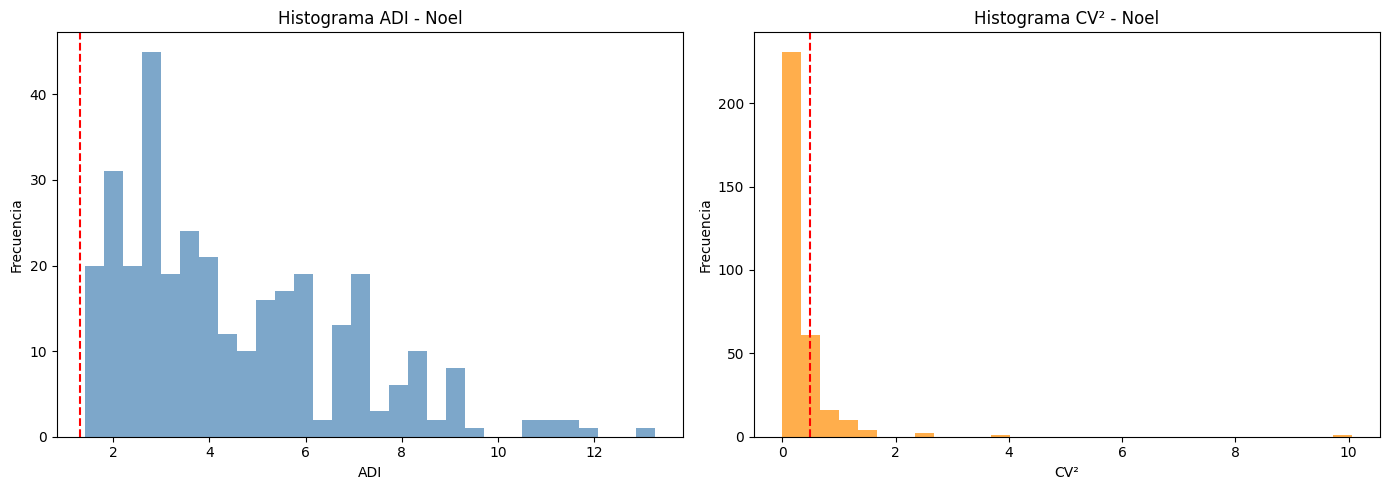

[Varma] Series totales: 365
[Varma] Series válidas: 358


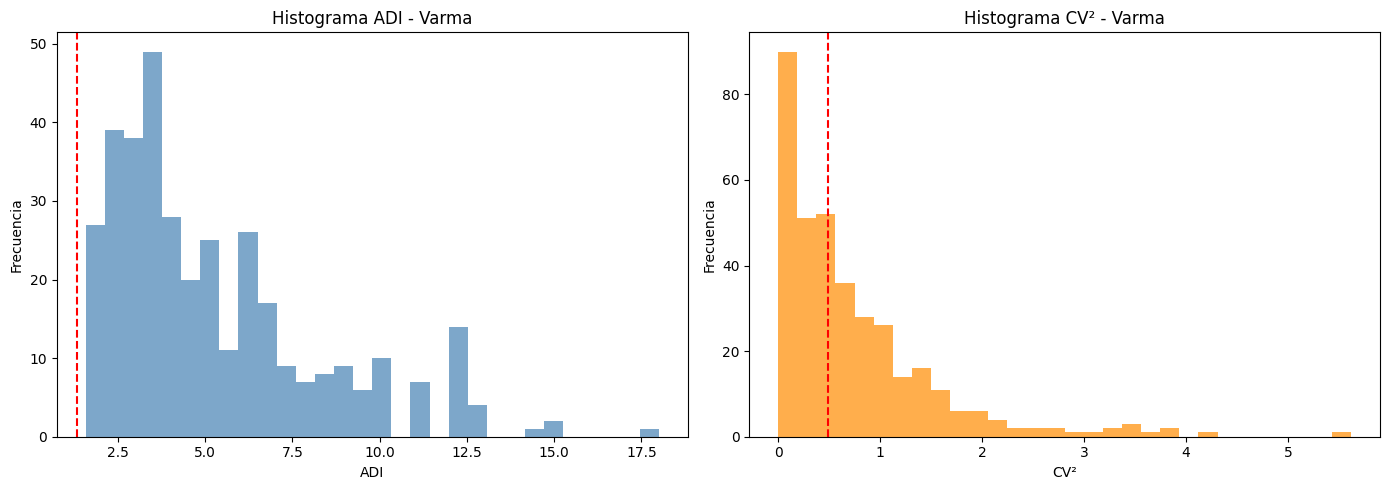

In [27]:
# Uso
plot_adi_cv2_histograms(df_Noel_summary, 'Noel')
plot_adi_cv2_histograms(df_Varma_summary, 'Varma')

#### 18. Graficar Series Individuales Representativas

El objetivo es graficar unas pocas series representativas de cada tipo de demanda (`Smooth`, `Erratic`, `Intermittent`, `Lumpy`), tomando ejemplos desde el DataFrame `df_filled` (con las series completas) y cruzándolo con `summary_df` (donde están las categorías ADI/CV²)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime

# Función para graficar ejemplos por categoría
def plot_examples_by_category(df_filled, summary_df,
                              ds_col = 'ds', id_col = 'unique_id', y_col = 'y', 
                              n_per_cat = 3, random_state = 42,
                              dataset_name = 'Dataset', save_fig = False):
    """
    Dibuja n_per_cat ejemplos por cada categoría de serie.
    Guarda la figura si save_fig = True.
    """

    categories = ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']
    valid_cats = [cat for cat in categories if not summary_df[summary_df['Cat'] == cat].empty]
    
    n_rows = len(valid_cats)
    if n_rows == 0:
        print('[!] No hay categorías con datos para graficar.')
        return
    
    fig, axes = plt.subplots(n_rows, n_per_cat,
                             figsize = (5 * n_per_cat, 3 * n_rows),
                             sharex = True)
    
    # Asegurar que axes es siempre 2D
    if n_rows == 1:
        axes = np.array([axes])
    if n_per_cat == 1:
        axes = axes.reshape((n_rows, 1))
    
    rng = np.random.default_rng(random_state)

    for i, cat in enumerate(valid_cats):
        # Filtrar los IDs de esa categoría
        ids = summary_df[summary_df['Cat'] == cat][id_col].unique()

        # Se elige aleatoriamente algunos IDs
        sample_ids = rng.choice(ids, size = min(n_per_cat, len(ids)), replace = False)

        for j, uid in enumerate(sample_ids):
            ts = df_filled[df_filled[id_col] == uid].sort_values(ds_col)

            ax = axes[i, j]
            ax.plot(ts[ds_col], ts[y_col], marker = 'x', linestyle = '-')
            ax.set_title(f'{cat} - ID: {uid}')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.tick_params(axis = 'x', rotation = 45)
            ax.grid(alpha = 0.3)
    
    plt.tight_layout()

    if save_fig:
        filename = f'ejemplos_series_{dataset_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png'
        plt.savefig(filename, dpi = 300)
        print(f'📁 Figura guardada como: {filename}')
        
    plt.show()


📁 Figura guardada como: ejemplos_series_Noel_20250813_095050.png


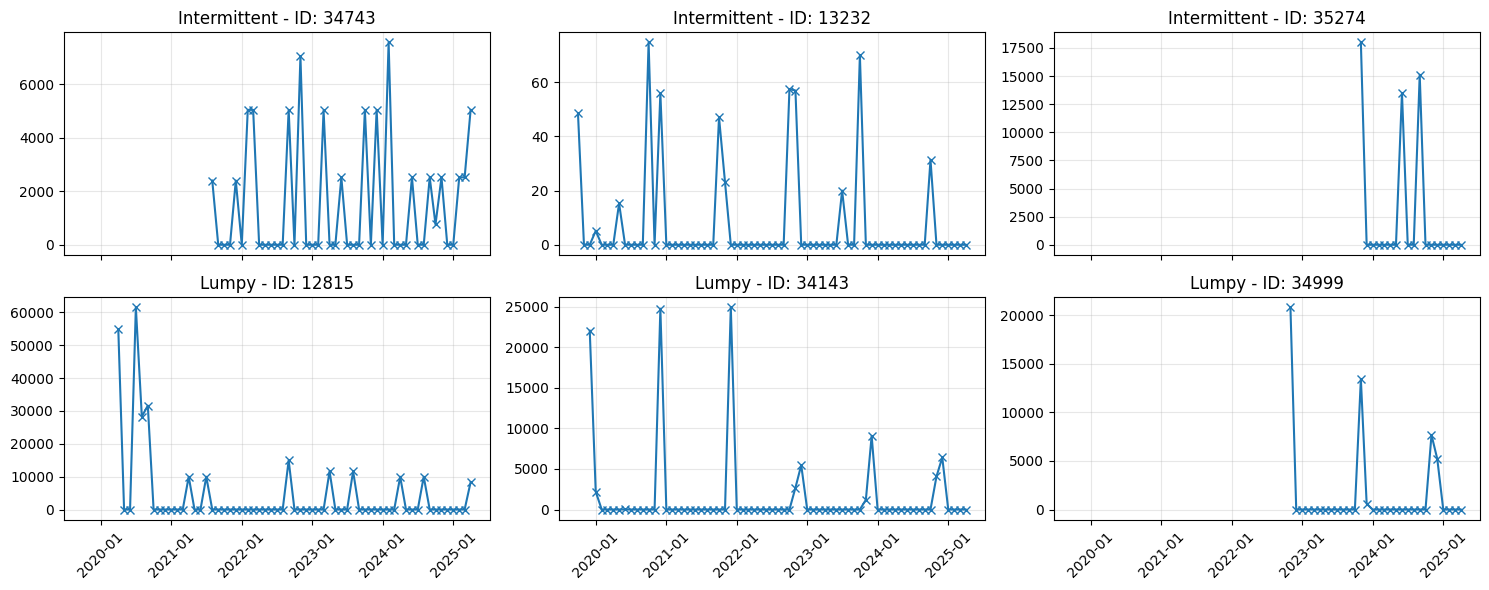

📁 Figura guardada como: ejemplos_series_Varma_20250813_095051.png


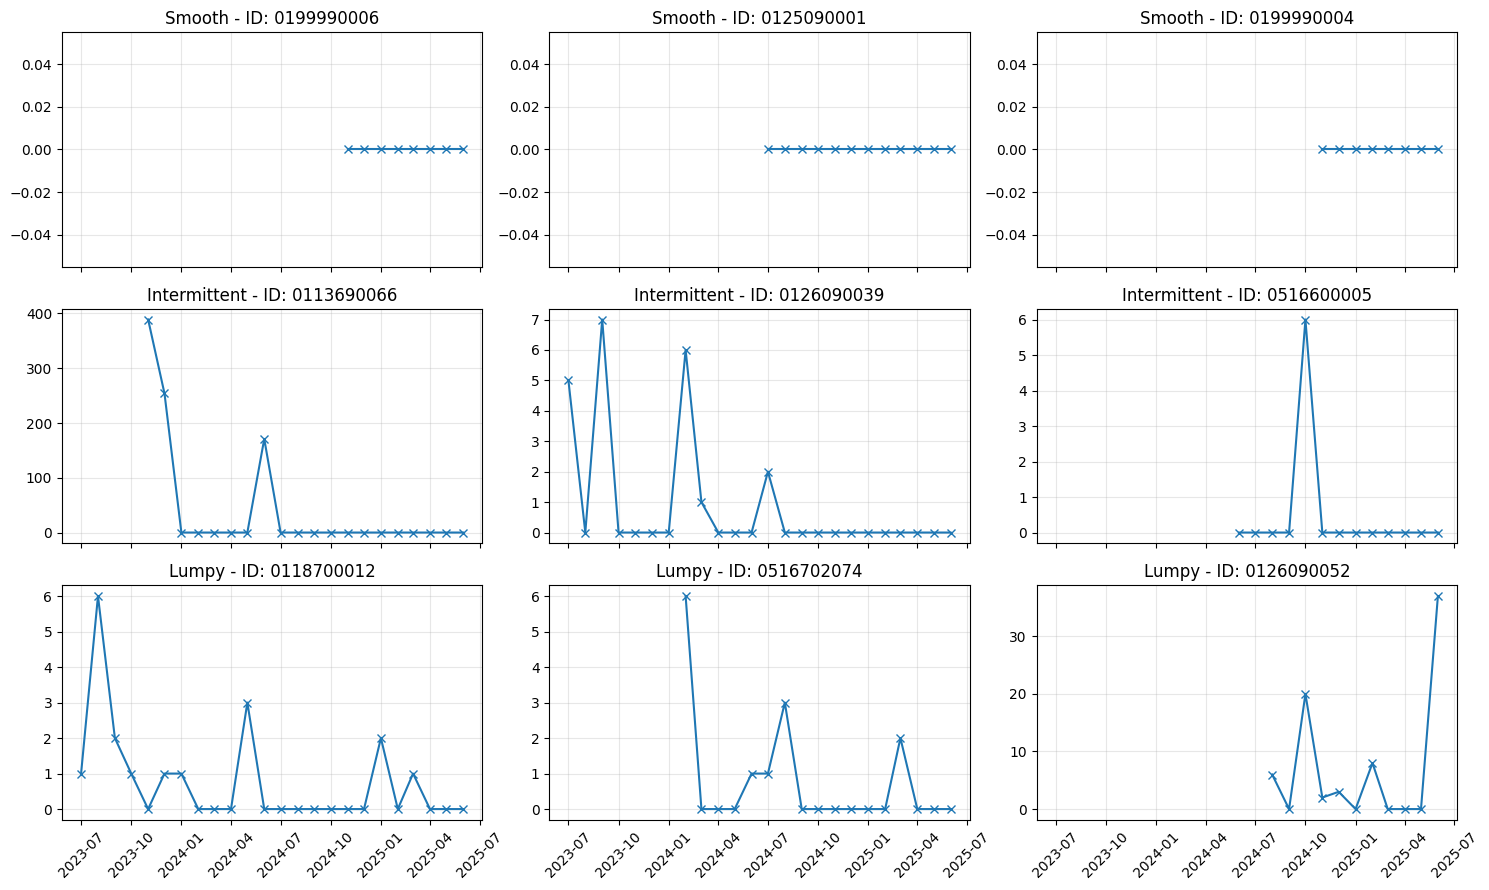

In [29]:
# Uso para Noel y Varma
plot_examples_by_category(df_Noel_filled, df_Noel_summary, 
                          dataset_name = 'Noel', save_fig = True)

plot_examples_by_category(df_Varma_filled, df_Varma_summary, 
                          dataset_name = 'Varma', save_fig = True)

#### 19. Graficar Métricas por Categoría mediante Boxplots

El objetivo es usar `summary_df` para graficar métricas descriptivas de las series, como `mean`, `std`, `CV2`, `ADI`, etc., agrupadas por `Cat`, **pero solo si hay datos en esa categoría**.

In [30]:
# Función plot_boxplots_by_category
def plot_boxplots_by_category(summary_df, metrics = ['mean', 'std', 'CV2', 'ADI'],
                              dataset_name = 'Dataset', save_fig = False):
    """
    Genera boxplots por métrica agrupando por categoría.
    Omite métricas o categorías vacías.
    """
    import seaborn as sns
    from datetime import datetime

    for metric in metrics:
        # Verificar si existe la columna
        if metric not in summary_df.columns:
            print(f"[!] Columna no encontrada: {metric}")
            continue

        # Filtrar categorías con datos válidos para la métrica
        df_metric = summary_df[['Cat', metric]].dropna()
        valid_cats = df_metric['Cat'].value_counts()[df_metric['Cat'].value_counts() > 0].index.tolist()

        if len(valid_cats) == 0:
            print(f"[!] No hay datos válidos para la métrica '{metric}'")
            continue

        plt.figure(figsize = (8, 5))
        sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')

        plt.title(f'Boxplot de {metric} por Categoría - {dataset_name}')
        plt.grid(alpha = 0.3)
        plt.tight_layout()

        if save_fig:
            filename = f"boxplot_{metric}_{dataset_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            plt.savefig(filename, dpi = 300)
            print(f"📁 Figura guardada como: {filename}")
        
        plt.show()

📁 Figura guardada como: boxplot_mean_Noel_20250813_095106.png


C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


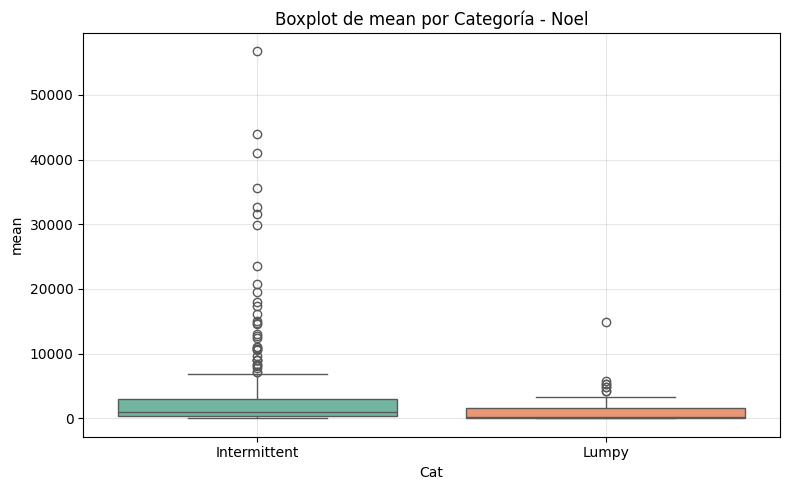

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_std_Noel_20250813_095106.png


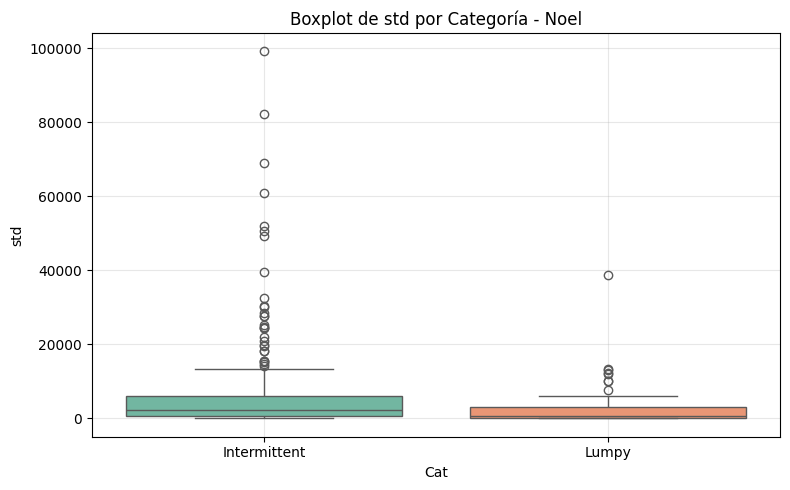

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_CV2_Noel_20250813_095106.png


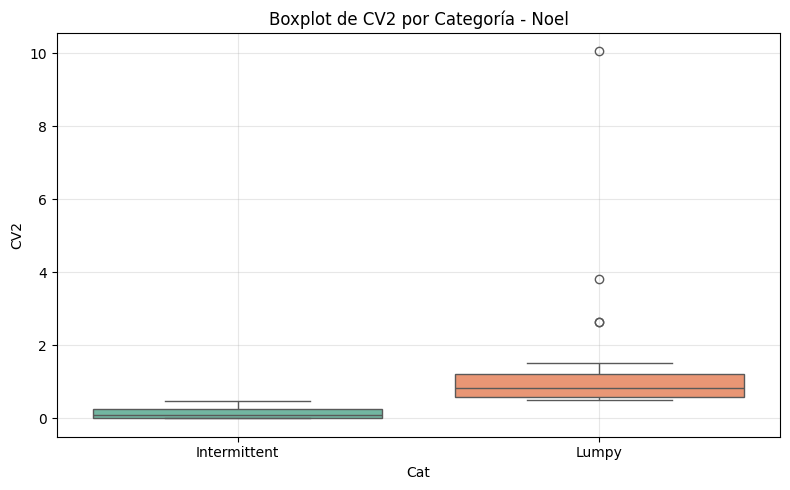

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_ADI_Noel_20250813_095106.png


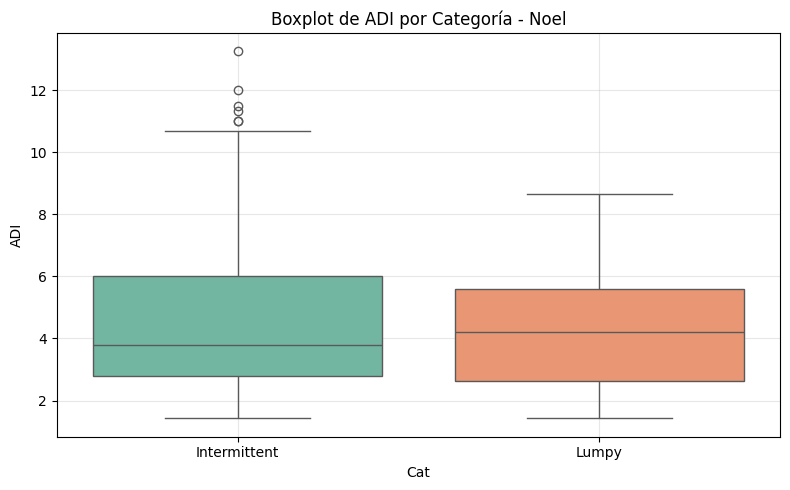

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_mean_Varma_20250813_095106.png


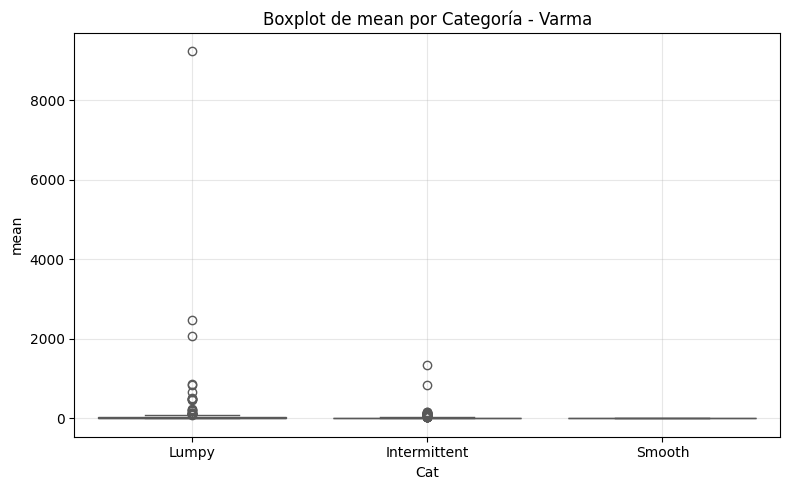

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_std_Varma_20250813_095106.png


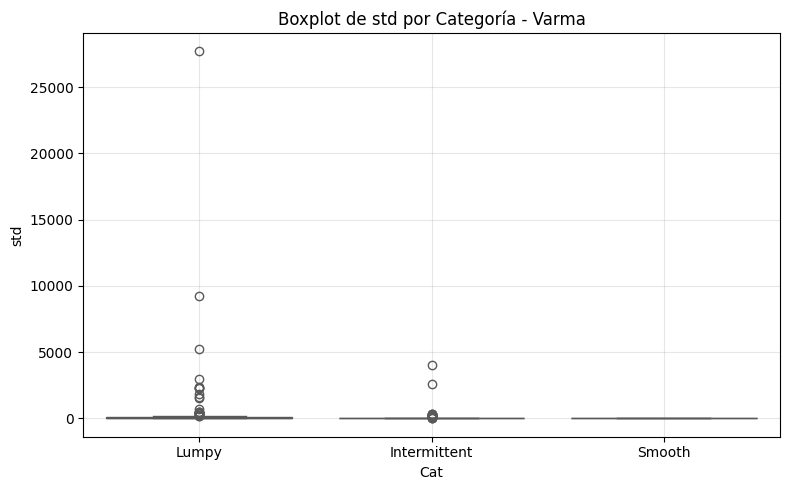

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_CV2_Varma_20250813_095107.png


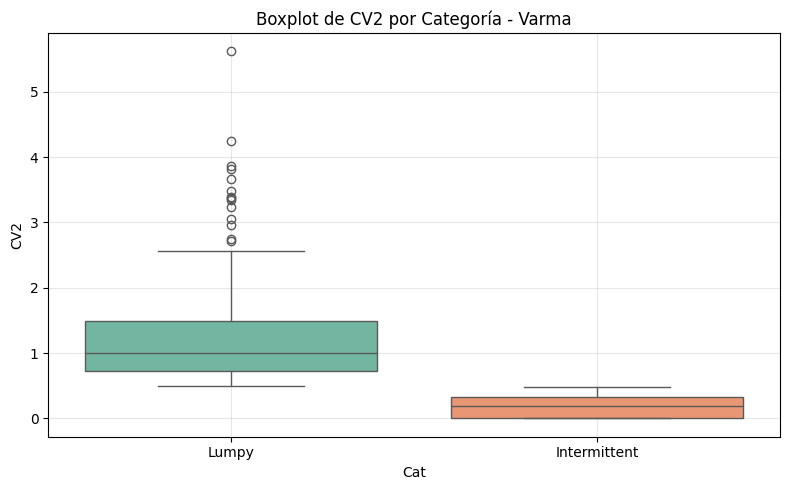

C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_5892\272533346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_metric[df_metric['Cat'].isin(valid_cats)], x = 'Cat', y = metric, palette = 'Set2')


📁 Figura guardada como: boxplot_ADI_Varma_20250813_095107.png


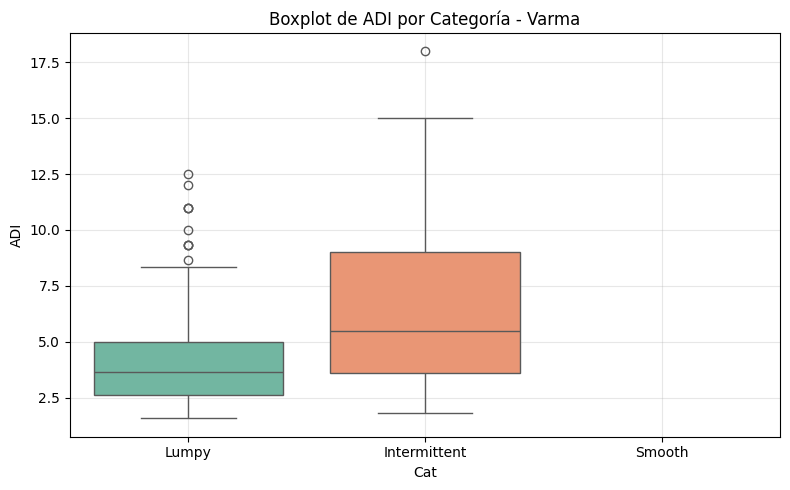

In [31]:
# Uso para Noel y Varma
plot_boxplots_by_category(df_Noel_summary, dataset_name = 'Noel', save_fig = True)
plot_boxplots_by_category(df_Varma_summary, dataset_name = 'Varma', save_fig = True)

Con estas funciones se logra:
- Ver ejemplos reales por tipo de serie y validar el comportamiento visual.
- Comparar métricas estadísticas por tipo y ver dispersiones o anomalías.
- Documentar resultados en archivos .png para informes o presentación.

---

#### 20. Clasificación del Estado de las Series

Evalúa si cada serie:
- Es suficientemente larga.
- Tiene datos relevantes.
- Es obsoleta.

📋 Criterios:
| Criterio         | Condición técnica                    | Estado asignado  |
| ---------------- | ------------------------------------ | ---------------- |
| **Obsoleta**     | Últimos 12 valores = 0               | `'Obsoleta'`     |
| **Insuficiente** | Menos de 12 registros                | `'Insuficiente'` |
| **NoApta**       | 2 o menos valores distintos de cero  | `'NoApta'`       |
| **Válida**       | No cumple ninguna condición anterior | `'Valida'`       |

Esto permite **filtrar automáticamente series poco útiles** para entrenamiento o evaluación.


In [32]:
# Función de clasificación:
def clasificar_estado_series(df, id_col = 'unique_id', ds_col = 'ds', y_col  = 'y',
                             n_obsoleta = 12, min_largo = 12, logging = True):
    """
    Clasifica series como 'Valida', 'Obsoleta', 'Insuficiente', 'NoApta'
    y genera un log de motivos de descarte.
    """
    estado_series = {}
    log_detalles = []

    for uid, grupo in df.groupby(id_col):
        serie = grupo.sort_values(ds_col)[y_col].values
        motivo = None

        # Criterio 1: Obsoleta -> últimos 12 valores == 0
        if len(serie) >= n_obsoleta and np.all(serie[-n_obsoleta:] == 0):
            estado = 'Obsoleta'
            motivo = f'Últimos {n_obsoleta} ceros'

        # Criterio 2: Insuficiente -> menos de 12 meses
        elif len(serie) < min_largo:
            estado = 'Insuficiente'
            motivo = f'Menos de {min_largo} períodos'
        
        # Cirterio 3: NoApta -> 2 o menso valores distintos de 0
        elif np.count_nonzero(serie) <= 2:
            estado = 'NoApta'
            motivo = '≤ 2 valores positivos'

        else:
            estado = 'Valida' # No cumple ningún criterio de descarte.
            motivo = '✔'
        
        estado_series[uid] = estado
        log_detalles.append((uid, estado, motivo))
    
    estado_df = pd.DataFrame.from_dict(estado_series,
                                       orient = 'index',
                                       columns = ['Estado']).reset_index().rename(columns = {'index': id_col})
    
    log_df = pd.DataFrame(log_detalles, columns = [id_col, 'Estado', 'Motivo'])

    if logging:
        print('📋 Resumen de estados:')
        print(estado_df['Estado'].value_counts())
        print()
    
    return estado_df, log_df
# Se guarda el resultado en un dataframe con columnas unique_id y Estado, que luego se fusiona con el resumen principal.

In [33]:
# Aplicar a los datasets
estado_Noel, log_Noel   = clasificar_estado_series(df_Noel_filled)
estado_Varma, log_Varma = clasificar_estado_series(df_Varma_filled)

📋 Resumen de estados:
Estado
Valida          228
Insuficiente     81
NoApta           17
Name: count, dtype: int64

📋 Resumen de estados:
Estado
Valida          241
Insuficiente     79
NoApta           39
Obsoleta          6
Name: count, dtype: int64



#### 21. Integración del estado al resumen

Esto añade una columna `'Estado'` en el resumen por serie (`df_*_summary`)
Te permite luego filtrar con facilidad: `df[df['Estado'] == 'Valida']`.

In [34]:
# Integrar del estado al resumen
# Merge con resumen
df_Noel_summary  = df_Noel_summary.merge(estado_Noel, on = 'unique_id')
df_Varma_summary = df_Varma_summary.merge(estado_Varma, on = 'unique_id')

#### 22. generate_horizon_dataframes() - Organización por Horizonte y Categoría

El **objetivo** es crear subconjuntos de datos que cumplan:
1. Estado = 'Valida'.
2. Categoría = Cat (Smooth, Lumpy, etc.)
3. Suficiente longitud para horiznte H (por default: ≥ 3×H)

Incluye:
- Guarda cada DataFrame generado con nombre dentro del `ddff` principal.
- Inyecta opcionalmente en `globals()` (controlado por parámetro).
- No necesita `globals()` para acceder a los dataframes generados.

In [35]:
def generate_horizon_dataframes(df_summary, df_filled, prefix, 
                                horizons = (3, 6, 12), min_mult = 3, 
                                inject_globals = True, logging = True):
    # Cambiar los valores del parámetro horizons a demanda.
    # Corto Plazo  (3 meses)
    # Medio Plazo  (6 meses)
    # Largo Plazo (12 meses)
    """
    Genera subconjuntos por categoría y horizonte, 
    y los guarda como DataFrames en un dict.
    También puede inyectarlos en el entorno global si se desea.
    """
    df_summary = df_summary.copy()

    # Crear flags de elegibilidad
    for h in horizons:
        df_summary[f'can_h{h}'] = df_summary['length'] >= (min_mult * h)
        # Por ejemplo, para h = 3, se marca True si la serie tiene al menos 9 registros.
    
    # Mapeo de categoría -> siglas
    siglas = {'Intermittent': 'ITS',
              'Smooth':       'STS',
              'Erratic':      'ETS',
              'Lumpy':        'LTS'}

    ddff = {}

    # Construcción de DataFrames por combinación
    for cat, abbr in siglas.items():
        for h in horizons:
            flag = f'can_h{h}'
            valid_ids = df_summary.loc[
                (df_summary['Estado'] == 'Valida') &    # <-- nuevo filtro
                (df_summary['Cat'] == cat) & 
                (df_summary[flag]),
                'unique_id'
            ]

            name = f"{prefix}_{abbr}_h{h}"
            
            # Generar DataFrames por combinación Categoría + Horizonte
            df_result = df_filled[df_filled['unique_id'].isin(valid_ids)].copy().sort_values(['unique_id', 'ds']).reset_index(drop = True)

            if not df_result.empty:
                ddff[name] = df_result
                if inject_globals:
                    globals()[name] = df_result
                if logging:
                    print(f'✅ {name}: {valid_ids.nunique()} series')

               
    # Por cada combinación (ITS, h = 3), crea un DataFrame llamado df_{prefix}_{SIGLA}_h{H}
    return df_summary, ddff

🧠 Ventajas con estas mejoras:
| Mejora implementada                           | Beneficio técnico                                  |
| --------------------------------------------- | -------------------------------------------------- |
| Logging de clasificación                      | Control de calidad de series                       |
| Log de motivos de descarte (`log_df`)         | Trazabilidad del filtrado                          |
| Parámetros configurables (`n_obsoleta`, etc.) | Flexibilidad                                       |
| Guardado en variables estructuradas (`ddff`)  | Facilidad para iterar, sin depender de `globals()` |
| Inyección opcional con `inject_globals`       | Control sobre el namespace del entorno             |


In [36]:
# Uso para Noel y Varma:
df_Noel_summary, Noel_ddff = generate_horizon_dataframes(df_Noel_summary, df_Noel_filled, prefix='df_Noel')
df_Varma_summary, Varma_ddff = generate_horizon_dataframes(df_Varma_summary, df_Varma_filled, prefix='df_Varma')

# Ya no necesitás filtrar "manualmente" para obtener los no vacíos: solo se agregan si tienen datos.
# Acceso directo:
df_Noel_ITS_h3 = Noel_ddff['df_Noel_ITS_h3']


✅ df_Noel_ITS_h3: 185 series
✅ df_Noel_ITS_h6: 171 series
✅ df_Noel_ITS_h12: 135 series
✅ df_Noel_LTS_h3: 43 series
✅ df_Noel_LTS_h6: 43 series
✅ df_Noel_LTS_h12: 34 series
✅ df_Varma_ITS_h3: 98 series
✅ df_Varma_ITS_h6: 80 series
✅ df_Varma_LTS_h3: 143 series
✅ df_Varma_LTS_h6: 116 series


In [37]:
# Extracción de los DDFF generales de Noel y Varma por tipo de demanda
# Lista de categorías y siglas
categorias = [('Intermittent', 'ITS'),
              ('Lumpy',        'LTS'),
              ('Smooth',       'STS'),
              ('Erratic',      'ETS')]

# Extraer DataFrames generales ITS, LTS, STS y ETS
for prefix, df_filled, df_summary in [('df_Noel',  df_Noel_filled,  df_Noel_summary), ('df_Varma', df_Varma_filled, df_Varma_summary)]:
    for cat, abbr in categorias:
        # IDs de series válidas en esa categoría
        valid_ids = df_summary.loc[(df_summary['Estado'] == 'Valida') & (df_summary['Cat'] == cat), 'unique_id']
        if valid_ids.nunique() > 0:
            var_name = f"{prefix}_{abbr}"
            globals()[var_name] = (df_filled
                                   .loc[df_filled['unique_id'].isin(valid_ids)]
                                   .sort_values(['unique_id', 'ds'])
                                   .reset_index(drop = True))
            print(f"Creado {var_name}: {globals()[var_name]['unique_id'].nunique()} series")
        else:
            print(f"No hay series válidas para {prefix} {cat}")

# 1. Recorre las cuatro categorías.
# 2. Para cada dataset (Noel y Varma), filtra las series con Estado == 'Valida' y Cat == categoría.
# 3. Crea variables globales df_Noel_ITS, df_Noel_LTS, etc., únicamente si existen series válidas.
# 4. Imprime un mensaje de confirmación indicando cuántas series contiene cada DataFrame generado.

# Estos son conjuntos sin filtrar por horizonte, pero útiles para análisis globales de cada tipo.

Creado df_Noel_ITS: 185 series
Creado df_Noel_LTS: 43 series
No hay series válidas para df_Noel Smooth
No hay series válidas para df_Noel Erratic
Creado df_Varma_ITS: 98 series
Creado df_Varma_LTS: 143 series
No hay series válidas para df_Varma Smooth
No hay series válidas para df_Varma Erratic


### Guardado de los DataFrames Resultantes (PUNTO DE CONTROL)

Este bloque permite **guardar**, **recargar** y **reiniciar** el trabajo sin reprocesar todo.

#### 23. Crear la carpeta de salida si no existe

In [38]:
# 1) Crear carpeta de salida si no existe
output_dir = 'series_filtradas'
os.makedirs(output_dir, exist_ok=True)

In [39]:
# 2) Guardar DataFrames de horizontes de Noel y Varma
for name, df in Noel_ddff.items():
    df.to_parquet(os.path.join(output_dir, f'{name}.parquet'), index=False)

for name, df in Varma_ddff.items():
    df.to_parquet(os.path.join(output_dir, f'{name}.parquet'), index=False)

In [40]:
# 3) Guardar subconjuntos generales (si existen)
for varname in ['df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS']:
    if varname in globals():
        df = globals()[varname]
        df.to_parquet(os.path.join(output_dir, f'{varname}.parquet'), index=False)
        print(f"💾 Guardado {varname} → {df.shape}")
    else:
        print(f"[!] Variable no encontrada: {varname} (no se guarda)")

💾 Guardado df_Noel_ITS → (9028, 3)
💾 Guardado df_Noel_LTS → (2364, 3)
💾 Guardado df_Varma_ITS → (2254, 3)
💾 Guardado df_Varma_LTS → (3468, 3)


#### 24. Función de recarga de DataFrames

- Recorre los .parquet del directorio.
- Si encuentra:
     - df_Noel_ITS, df_Noel_LTS, etc.: los carga y los inyecta en globals().
     - Otros: los guarda en Noel_ddff o Varma_ddff.

Esta función hace:
- Persistencia del pipeline.
- Recarga rápida después de reiniciar kernel.
- Separación entre subconjuntos generales y por horizonte.

In [41]:
# 4) Función para recargar series desde 'series_filtradas'
def load_all_series(base_dir='series_filtradas', inject_globals=True, logging=True):
    """
    Carga todos los .parquet del directorio:
    - Reinyecta df_Noel_ITS, df_Noel_LTS, etc. si inject_globals=True.
    - Devuelve dos dicts con los DataFrames por horizonte y uno con los generales.
    """
    Noel_ddff = {}
    Varma_ddff = {}
    generales = {}

    for fname in os.listdir(base_dir):
        if not fname.endswith('.parquet'):
            continue
        key = fname[:-8]  # eliminar ".parquet"
        df = pd.read_parquet(os.path.join(base_dir, fname))

        if logging:
            print(f"📁 Cargado: {key} – shape: {df.shape}")

        if key in ('df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS'):
            generales[key] = df
            if inject_globals:
                globals()[key] = df
        elif key.startswith('df_Noel_'):
            Noel_ddff[key] = df
        elif key.startswith('df_Varma_'):
            Varma_ddff[key] = df

    return Noel_ddff, Varma_ddff, generales

# Ejemplo de uso:
# Noel_ddff, Varma_ddff, generales = load_all_series()
# df_Noel_ITS = generales['df_Noel_ITS']

In [42]:
# # Hasta el momento tengo los siguientes dataframes:
# # NOEL Intermittent                   |  # # NOEL Lumpy
# df_Noel_ITS     (9028, 3) 185 Series  |  # df_Noel_LTS     (2364, 3)  43 Series
# df_Noel_ITS_h1  (9028, 3) 185 Series  |  # df_Noel_LTS_h1  (2364, 3)  43 Series
# df_Noel_ITS_h3  (9028, 3) 185 Series  |  # df_Noel_LTS_h3  (2364, 3)  43 Series
# df_Noel_ITS_h6  (8831, 3) 171 Series  |  # df_Noel_LTS_h6  (2364, 3)  43 Series
# df_Noel_ITS_h9  (8391, 3) 149 Series  |  # df_Noel_LTS_h9  (2241, 3)  37 Series
# df_Noel_ITS_h12 (7951, 3) 135 Series  |  # df_Noel_LTS_h12 (2148, 3)  34 Series

# # VARMA Intermittent                  |  # # VARMA Lumpy
# df_Varma_ITS    (2254, 3)  98 Series  |  # df_Varma_LTS    (3468, 3) 143 Series
# df_Varma_ITS_h1 (2254, 3)  98 Series  |  # df_Varma_LTS_h1 (3468, 3) 143 Series
# df_Varma_ITS_h3 (2254, 3)  98 Series  |  # df_Varma_LTS_h3 (3468, 3) 143 Series
# df_Varma_ITS_h6 (2011, 3)  80 Series  |  # df_Varma_LTS_h6 (3093, 3) 116 Series
# df_Varma_ITS_h9 ( 898, 3)  31 Series  |  # df_Varma_LTS_h9 (2005, 3)  69 Series

---
Hasta aquí se tiene implementado un **pipeline robusto, flexible y escalable** que incluye:
- Bloque 0: Limpieza y Formateo. Resultado: (df_{nombre}_filled)
- Bloque 1: Clasificación ADI/CV². Resultado: (df_{nombre}_summary)
- Bloque 2: Clasificación por estado de utilidad. Resultado: Añade columna Estado.
- Bloque 3: Flags de horizonte + Segmentación por tipo. Resultado: (df_{nombre}_{perfil}_{horizonte})
- Bloque 4: Persistencia y recarga. Resultado: (.parquet)(load_all_series())
---

A partir de aquí, las ideas para continuar el proyecto se dividen en bloques funcionales:
---
🔷 Bloque 5 – Visualización Exploratoria e Interpretación
- 📊 Gráficos por tipo de demanda: Time series plots para ejemplos representativos de cada tipo.
- 🧭 Exploración de patrones: estacionalidad, tendencias, ciclos.
- 📌 Distribución de ADI y CV²: Histogramas, scatterplots, etc.
---
🔷 Bloque 6 – Selección y Preparación para Forecasting
- ✅ Selección de series o subconjuntos según criterios (por tipo de demanda, volumen, estabilidad…)
- 🧼 Normalización / transformación (log, Box-Cox, etc.) si hace falta
- 📉 División train-test para cada serie u horizonte
---
🔷 Bloque 7 – Modelado

Probar distintos modelos según el tipo de serie y horizonte:
- 🔹 Modelos estadísticos: Croston, TSB, ARIMA, Holt-Winters, SES
- 🔹 Modelos ML clásicos: Random Forest, XGBoost, etc. (opcional)
- 🔹 Modelos automáticos: Prophet, AutoETS, AutoARIMA, etc.
- 🔹 Redes neuronales recurrentes (LSTM) si el tiempo lo permite
---
🔷 Bloque 8 – Evaluación y Comparación
- 📏 Métricas: MAE, RMSE, MASE, sMAPE
- 📉 Gráficos de error por tipo de serie / horizonte
- 📚 Ranking de modelos por tipo de demanda
---
🔷 Bloque 9 – Dashboard / Reporte Final
- 📊 Visualizaciones interactivas en Power BI, Tableau o Jupyter con plotly o panel
- 📝 Resumen de hallazgos por tipo de demanda, modelo y rendimiento
- 💡 Recomendaciones finales (por ejemplo, “usar Croston para Lumpy, Holt para Smooth…”)
---
BONUS (si hay tiempo):
- 🔁 Pipeline automatizado con funciones o clases reutilizables
- 🔄 Validación cruzada o walk-forward para evaluar robustez
- 🧠 Forecast ensembles por tipo de demanda
---

📊 5. ¿Cómo medir diferentes métricas tanto en promedio por horizonte como en promedio/suma mensual dentro de cada horizonte?

Para esto, necesitas organizar las predicciones en una estructura tabular clara, con columnas como:

split_id | timestamp | y_true | y_pred | modelo | horizonte | mes_predicho

Luego puedes agrupar y calcular:
a) Promedio por horizonte:

df.groupby(['modelo', 'horizonte'])['MAE'].mean()

b) Promedio mensual (dentro del horizonte):

df['mes_predicho'] = df['timestamp'].dt.to_period('M')
df.groupby(['modelo', 'mes_predicho'])['MAE'].mean()

c) Suma mensual por horizonte:

df.groupby(['modelo', 'mes_predicho'])['y_true', 'y_pred'].sum()

Esto es especialmente útil si:
- Quieres evaluar rendimiento agregado (por ejemplo, total de unidades mal predichas en un mes).
- O si hay estacionalidad mensual y necesitas saber en qué meses falla más cada modelo.

✅ Resumen final
| Pregunta                                  | Resumen breve                                                                 |
| ----------------------------------------- | ----------------------------------------------------------------------------- |
| ¿Se pueden combinar expanding y rolling?  | Sí, en enfoque híbrido según evolución del modelo.                            |
| ¿Cuál es mejor para demanda intermitente? | Rolling window, mejor adaptabilidad a picos y ceros.                          |
| ¿Cómo aplicarlo a distintos horizontes?   | Entrenar con backtesting y predecir a varios `h`, analizar por horizonte.     |
| ¿Cómo probar varios modelos?              | Loop o clase parametrizable donde cada modelo entrena y predice por separado. |
| ¿Cómo evaluar métricas detalladas?        | Usa estructuras con `split`, `modelo`, `horizonte`, `mes`; agrupa y analiza.  |


---

In [42]:
# Crear un esquema de modelos para forecasting de demanda intermitente
model_categories = {
    "Benchmark": ["Naïve", "Seasonal Naïve", "Naïve with Drift", "Moving Average"],
    "Estadísticos": ["Croston", "SBA (Syntetos-Boylan)", "TSB (Teunter-Syntetos-Babai)", "ARIMA", "ETS"],
    "Machine Learning": ["XGBoost", "Random Forest", "LightGBM", "Gradient Boosting"],
    "Deep Learning": ["LSTM", "GRU", "Transformer", "N-BEATS", "DeepAR"]
}

# Convertirlo a un dataframe para mostrar
df_models = pd.DataFrame([(cat, model) for cat, models in model_categories.items() for model in models],
                         columns=["Categoría", "Modelo"])

import ace_tools as tools; tools.display_dataframe_to_user(name="Modelos para Forecasting", dataframe=df_models)

ModuleNotFoundError: No module named 'ace_tools'

🧠 ¿Tiene sentido dividir cada serie en tres segmentos para todos los modelos?

✅ Resumen y Contexto

Dividir los datos en train, validation y test es una práctica común en aprendizaje automático (machine/deep learning), pero no es siempre necesaria para modelos estadísticos clásicos.

📊 Modelos Estadísticos (Croston, TSB, ARIMA, etc.)
Suelen funcionar con división train/test.

El test se usa para validar el rendimiento del modelo una vez entrenado sobre el conjunto train.

No requieren ajuste de hiperparámetros intensivo, por lo que el validation no es imprescindible.

🤖 Modelos de Machine Learning / Deep Learning
Aquí sí es recomendable una división en train/validation/test:

train: Entrenamiento del modelo.

validation: Selección de hiperparámetros / arquitectura.

test: Evaluación final (fuera del proceso de entrenamiento).

Además, se puede aplicar TimeSeriesSplit o Expanding Window Cross-Validation para evaluar la estabilidad del modelo a lo largo del tiempo.

🧪 Cross Validation en Series Temporales
NO aleatoria: las divisiones deben respetar la estructura temporal.

Puedes usar:

Ventana deslizante (rolling): tamaño fijo de train, se desplaza a lo largo del tiempo.

Ventana de expansión (expanding): se entrena con datos crecientes.


⚙️ Esquema para montar un Backtester flexible


In [ ]:
class TimeSeriesBacktester:
    def __init__(self, model, strategy='expanding', horizon=12):
        self.model = model
        self.strategy = strategy
        self.horizon = horizon
        self.results = []

    def split_series(self, series):
        # Implementar lógica de ventana deslizante o de expansión
        pass

    def fit_predict(self, train, test):
        # Entrenar y predecir con el modelo
        pass

    def evaluate(self, y_true, y_pred):
        # Calcular métricas como MAE, RMSE, MASE, etc.
        pass

    def run(self, series):
        for fold in self.split_series(series):
            y_pred = self.fit_predict(fold.train, fold.test)
            metrics = self.evaluate(fold.test, y_pred)
            self.results.append(metrics)

        return pd.DataFrame(self.results)
# Este backtester puede ser usado con modelos benchmark, estadísticos, ML y DL (con ligeras adaptaciones).

📌 ¿Qué modelos puedo probar según el enfoque?
| Categoría        | Modelos Principales                                     |
| ---------------- | ------------------------------------------------------- |
| Benchmark        | Naïve, Seasonal Naïve, Naïve with Drift, Moving Average |
| Estadísticos     | Croston, SBA, TSB, ARIMA, ETS                           |
| Machine Learning | XGBoost, LightGBM, Random Forest, Gradient Boosting     |
| Deep Learning    | LSTM, GRU, Transformer, DeepAR, N-BEATS                 |

🧩 ¿Cómo probar modelos por separado y unificar resultados?
Entrena y evalúa cada modelo por separado con tu esquema de backtesting.

Guarda cada conjunto de métricas en un DataFrame con columna modelo.

Concatena todos los resultados:

In [ ]:
df_final = pd.concat([df_naive, df_croston, df_xgboost, df_lstm], axis=0)
df_final.groupby(['modelo', 'horizonte']).agg(['mean', 'sum'])

---
🔧 BLOQUE FUNCIONAL DE BACKTESTING: ESTRUCTURA GENERAL

1. Iteración principal del sistema
- El sistema recorre los DataFrames df_{cliente}_{tipo}_h{H}.
- Cada DataFrame contiene:
     - Series válisas ya filtradas.
     - Mismo cliente, tipo de demanda, y horizonte.
- Cada iteración ejecuta un experimento sobre una combinación:
    (dataset, tipo_demanda, horizonte) → múltiples modelos → múltiples estrategias de entrenamiento)

2. Estrategias de entrenamiento

Se deben implementar tres estrategias de split temporal por modelo y horizonte:
- Expanding Window
- Rolling Window
- Mixto (Expanding → Rolling en bloques)
Cada estrategia afecta a cómo se genera el conjunto de entrenamiento en cada corte temporal, pero siempre con horizonte fijo (h predeterminado por el nombre del DataFrame).

3. Tipo de Split (2-way vs 3-way)
- Se define ua estructura de decisión para aplicar el tipo correcto de split:
     - Split 2 (Train/Test):
         - Para modelos estadísticos tradicionales.
     - Splot 3 (Train/Val/Test):
         - Para modelos de Machine Learning y Deep Learning.
         - Facilita tuning de hiperparáetros en validación.

4. Modelos y librerías

Cada modelo se ejecuta con los parámetros apropiados según su librería:
| Modelo         | Librerías compatibles            |
| -------------- | -------------------------------- |
| Naïve          | `statsforecast`, `sktime`        |
| Seasonal Naïve | `statsforecast`, `sktime`        |
| Drift          | `statsforecast`, `sktime`        |
| Moving Avg     | `statsforecast`, `sktime`        |
| Croston        | `pyinterdemand`, `statsforecast` |
| SBA, SBJ, TSB  | `pyinterdemand`, `statsforecast` |
| SES, LES, HES  | `pyinterdemand`, `statsforecast` |
| ADIDA          | `pyinterdemand`, `statsforecast` |
| ARIMA          | `statsmodels`                    |
| ETS            | `statsmodels`                    |
| AutoARIMA      | `pmdarima`, `statsforecast`      |
| AutoETS        | `statsforecast`                  |

5. Backtesting: Flujo Funcional

Por cada DataFrame:
     1. 🔁 Iterar modelos compatibles con ese split.
     2. 🔁 Iterar estrategia de entrenamiento (expanding, rolling, mix).
     3. 📦 Generar splits y ejecutar predicciones.
     4. 💾 Guardar predicciones y verdaderos (y_pred, y_true) por ventana.
     5. 📊 Calcular métricas:
         - Globales por serie.
         - Promedio por paso del horizonte.
         - Suma por paso del horizonte.
     6. 🗃️ Almacenar resultados en estructuras tipo DataFrame o dict.

6. Métricas a calcular

Para cada modelo-horizonte:
| Nivel de agregación                | Propósito                       |
| ---------------------------------- | ------------------------------- |
| 🔹 Promedio global (1 valor)       | Comparación general del modelo  |
| 🔹 Promedio por paso del horizonte | Ver evolución del error por mes |
| 🔹 Suma por paso del horizonte     | Acumulado de errores por mes    |

Ejemplo (h = 3):
 - MAE_prom: media global.
 - MAE_step_1, MAE_step_2, MAE_step_3.
 - MAE_sum_1, MAE_sum_2, MAE_sum_3.

7. Comparación final

Tres tablas por horizonte:
 - Tabla 1: Métrica agregada global por modelo.
 - Tabla 2: Promedio por paso del horizonte.
 - Tabla 3: Suma por paso del horizonte.

Cada fila es un modelo.
Cada columna es una métrica o una combinación (métrica, paso).

8. Requisitos técnicos adicionales
- ✳️ Nombrado estandarizado: para modelos, horizontes, clientes y tipo de estrategia.
- 📦 Modularización del código:
     - Funciones para splits.
     - Funciones para entrenamiento.
     - Funciones para métricas.
     - Funciones para resumen y exportación.
- ✅ Validación de formatos de entrada (tipo datetime, freucencia, etc.)
- 🔧 Posibilidad de establecer random_state para reproducibilidad en ML.
- 📁 Posibilidad de guardar resultados parciales para evitar recomputar.

---

## 1. ESQUEMA BASE DE FUNCIONES / MÓDULOS

Vamos a dividir el sistema en bloques funcionales modulares para maximizar la reutilización y mantener todo organizado y extensible.

### 🔧 Modulos principales:
| Módulo                         | Descripción                                                                 |
| ------------------------------ | --------------------------------------------------------------------------- |
| `prepare_split()`              | Divide la serie en train/test o train/val/test según el tipo de modelo      |
| `generate_backtest_windows()`  | Genera las ventanas según la estrategia: expanding, rolling o mixta         |
| `train_and_forecast_model()`   | Entrena el modelo y genera predicciones para una ventana                    |
| `evaluate_predictions()`       | Calcula métricas agregadas, promedio por paso y suma por paso               |
| `run_backtest_for_model()`     | Ejecuta todo el flujo de backtesting para un modelo, horizonte y estrategia |
| `compare_all_models()`         | Ejecuta `run_backtest_for_model` sobre todos los modelos                    |
| `summarize_backtest_results()` | Organiza las métricas en formato tabular final                              |

## 2. ESTRATEGIAS DE ENTRENAMIENTO + SPLIT

A continuación, se presenta la lógica de la función para implementar las estrategias `expanding`, `rolling` y `mixta`, y el split de tipo 2 o 3.

### 🔹prepare_split(df, split_type = '2way', val_size = 0.1, test_size = 0.2)

Entrada:
- `df`: DataFrame con una única serie (una combinación `unique_id`)
- `split_type`: `'2way'` o `'3way'`.
- Tamaños relativos para validación y test.

Salida:
- Diccionario con partes: `train`, `val`, `test`.

**Esquema de comportamiento**:

In [ ]:
def prepare_split(df, split_type = '2way', val_size = 0.1, test_size = 0.2):
    """
    Split temporal de una serie (por unique_id).
    """
    df = df.sort_values('ds')
    n = len(df)

    if split_type == '2way':
        test_start = int(n * (1 - test_size))
        return {
            'train': df.iloc[:test_start],
            'test':  df.iloc[test_start:]
        }
    
    elif split_type == '3way':
        val_start =  int(n * (1 - (val_size + test_size)))
        test_start = int(n * (1 - test_size))
        return {
            'train':      df.iloc[:val_start],
            'validation': df.iloc[val_start:test_start],
            'test':       df.iloc[test_start:]
        }

### 🔹generate_backtest_windows(df, horizon, window_type = 'expanding', step_size = 1, min_train_size = None)

Entrada:
- `df`: serie temporal individual (por ID)
- `horizon`: int, número de pasos de predicción.
- `window_type`: `'expanding'`, `'rolling'` o `'mixed'`.
- `step_size`: cuántos pasos se mueve la ventana.
- `min_train_size`: tamaño mínimo de ventana de entrenamiento.

Salida:
- Lista de pares `(train_window, test_window)` para cada corte temporal.

**Esquema de comportamiento**:

In [ ]:
def generate_backtest_window(df, horizon, window_type = 'expanding', step_size = 1, min_train_size = None):
    df = df.sort_values('ds').reset_index(drop = True)
    windows = []
    n = len(df)

    if min_train_size is None:
        min_train_size = 3 * horizon
    
    max_start = n - horizon
    start = min_train_size

    while start <= max_start:
        if window_type == 'expanding':
            train = df.iloc[:start]
        elif window_type == 'rolling':
            train = df.iloc[start - min_train_size:start]
        elif window_type == 'mixed':
            buffer = int(min_train_size / 2)
            train = df.iloc[start - buffer:start]
        else:
            raise ValueError('Invalid window_type')
        
        test = df.iloc[start:start + horizon]
        windows.append((train.copy(), test.copy()))
        start += step_size

    return windows

## 3. MÓDULOS DE ENTRENAMIENTO Y PREDICCIÓN POR VENTANA

### 🧩 train_and_forecast_model(model_name, train, horizon, freq, seasonal_perid = None, **kwargs)

El objetivo es entrenar un modelo sobre un `train` DataFrame (una sola serie temporal) y devolver la predicción de `horizon` pasos hacia adelante.

✅ **Supuestos de entrada**:
- `train`: DataFrame con columnas `['unique_id', 'ds', 'y']` y una sola serie.
- `model_name`: string que identifica el modelo (por ejemplo: `'naive'`, `'autoarima'`, `'croston'`, etc.).
- `horizon`: entero, número de pasos de forecast.
- `freq`: frecuencia temporal de la serie (`'M'`, `'W'`, `'D'`, etc.)
- `seasonal_period`: usado para modelos estacionales o con parámetro `sp` (ej. naive, estacional, ETS...)
- `kwargs`: parámetros adicionales específicos del modelo.

🧱 **Estructura del módulo**:

Se estructura en tres bloques:
1. Normalización de entrada.
2. Mapeo de `model_name` → implementación.
3. Entrenamiento y predicción.

🧪 **Versión inicial del código base**:

In [ ]:
# Versión inicial del código base para entrenamiento y predicción:
from statsforecast import StatsForecast
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import Drift
from statsforecast.models import AutoARIMA
from statsforecast.models import AutoETS
from statsforecast.models import CrostonClassic
from statsforecast.models import CrostonOptimized
from statsforecast.models import CrostonSBA
from statsforecast.models import CrostonSBJ
from statsforecast.models import TSB
from statsforecast.models import MmoveringAverage
from statsforecast.models import SES
from statsforecast.models import LES
from statsforecast.models import HES
from statsforecast.models import ADIDA

import pandas as pd

SyntaxError: Expected one or more names after 'import' (1081796314.py, line 4)

---
# FORMULAS
---

**MSE - Mean Squared Error**

$\text{MSE}(y, \hat{y}) = \frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}$

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_squared_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.MSE(multi_output="raw_values"))

**RMSE - Root Mean Square Error**

$\text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}}$

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.root_mean_squared_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.RMSE(multi_output="raw_values"))

**MAPE - Mean Absolute Percentage Error**

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_absolute_percentage_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.MAPE(multi_output="raw_values"))

**SMAPE - Symmetric Mean Absolute Percentage Error**

$\text{SMAPE}(y, \hat{y}) = \frac{100\%}{N} \sum_{i=0}^{N - 1} \frac{ 2*|y_i - \hat{y}_i|}{|y| + |\hat{y}|}$

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.symmetric_mean_absolute_percentage_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.SMAPE(multi_output="raw_values"))

**MAAPE - Mean Arctangent Absolute Percentage Error**

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_arctangent_absolute_percentage_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.MAAPE(multi_output="raw_values"))

**MASE - Mean Absolute Scaled Error**

$\text{MASE}(y, \hat{y}) = \frac{ \frac{1}{N} \sum_{i=0}{N-1} |y_i - \hat{y_i}| }{ \frac{1}{N-1} \sum_{i=1}^{N-1} |y_i - y_{i-1}| }$

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_absolute_scaled_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.MASE(multi_output="raw_values"))

**PCD - Prediction of Change in Direction**

$\text{PCD}(y, \hat{y}) = \frac{1}{n-1} \sum_{i=2}^{n} I\left((f_{i}-f_{i-1}) (y_{i}-y_{i-1}) > 0\right)$

where $f_i$ is the predicted value at time $i$, $y_i$ is the actual value at time $i$, $n$ is the total number of predictions, and $I(cdot)$ is the indicator function which equals 1 if the argument is true and 0 otherwise.

Best possible score is 1.0, bigger value is better. Range = [0, 1]

The Prediction of Change in Direction (PCD) metric is used to evaluate the performance of regression models on detecting changes in the direction of a target variable.

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.prediction_of_change_in_direction())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.PCD(multi_output="raw_values"))

**RSE - Residual Standard Error**

$\text{RSE}(y, f_i) = \sqrt{\frac{\sum_{i=1}^{n}(y_i - f_i)^2}{n-p-1}}$

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.residual_standard_error())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.RSE(multi_output="raw_values"))

**OI - Overall Index**

$\text{OI}(y, \hat{y}) = \frac{1}{2} \biggr[ 1 - \frac{RMSE}{y_{max} - y_{min}} + EC \biggr]$

The Overall Index (OI) is a composite measure used to evaluate the accuracy of a forecasting model. It combines the Root Mean Squared Error (RMSE) with a measure of the relative error and a correction term.

Best possible value = 1, bigger value is better. Range = [-1, +1)

In [ ]:
from numpy import array
from permetrics.regression import RegressionMetric

## For 1-D array
y_true = array([3, -0.5, 2, 7])
y_pred = array([2.5, 0.0, 2, 8])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.overall_index())

## For > 1-D array
y_true = array([[0.5, 1], [-1, 1], [7, -6]])
y_pred = array([[0, 2], [-1, 2], [8, -5]])

evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.OI(multi_output="raw_values"))

**ROC-AUC**

ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) is a metric used to evaluate the performance of a binary classification model. It is a measure of how well the model is able to distinguish between positive and negative classes.

A ROC curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The TPR is the ratio of the number of true positives to the total number of positives, while the FPR is the ratio of the number of false positives to the total number of negatives.

The AUC is the area under the ROC curve. It ranges between 0 and 1, where a value of 0.5 represents a model that performs no better than random guessing, and a value of 1 represents a model that makes perfect predictions. A higher AUC value indicates that the model is better at distinguishing between the positive and negative classes.

Interpretation of the ROC curve and AUC value depends on the specific problem and domain. In general, a model with an AUC value of 0.7 to 0.8 is considered acceptable, while a value greater than 0.8 is considered good. However, the interpretation may vary depending on the specific use case and the cost of false positives and false negatives.

In the multi-class and multi-label case, this is the average of the AS score of each class with weighting depending on the average parameter.

In a multiclass classification problem, ROC-AUC can still be used as a metric, but it requires some modifications to account for the multiple classes.

One approach is to use the one-vs-all (OvA) strategy, where we train a binary classifier for each class, treating it as the positive class and all other classes as the negative class. For each class, we calculate the ROC curve and AUC value, and then average the AUC values across all classes to obtain a single metric.

Another approach is to use the one-vs-one (OvO) strategy, where we train a binary classifier for each pair of classes, treating one class as the positive class and the other as the negative class. For each pair of classes, we calculate the ROC curve and AUC value, and then average the AUC values across all pairs to obtain a single metric.

In either case, it is important to ensure that the classes are balanced, meaning that the number of examples in each class is roughly equal, or to use appropriate sampling techniques to handle class imbalance.

It is worth noting that ROC-AUC may not always be the best metric for multiclass problems, especially when the classes are highly imbalanced or the cost of false positives and false negatives varies across classes. In such cases, other metrics such as precision, recall, F1-score, or weighted average of these metrics may be more appropriate.



In [ ]:
from numpy import array
from permetrics.classification import ClassificationMetric

## For integer labels or categorical labels
y_true = [0, 1, 0, 0, 1, 0]
y_score = [0, 1, 0, 0, 0, 1]

y_true = np.array([0, 1, 2, 1, 2, 0, 0, 1])
y_score = np.array([[0.8, 0.1, 0.1],
           [0.2, 0.5, 0.3],
           [0.1, 0.3, 0.6],
           [0.3, 0.7, 0.0],
           [0.4, 0.3, 0.3],
           [0.6, 0.2, 0.2],
           [0.9, 0.1, 0.0],
           [0.1, 0.8, 0.1]])

cm = ClassificationMetric(y_true, y_pred)

print(cm.roc_auc_score(y_true, y_score, average=None))
print(cm.ROC(y_true, y_score))
print(cm.AUC(y_true, y_score, average="macro"))
print(cm.RAS(y_true, y_score, average="weighted"))

---
---
---

SIGUIENTE BLOQUE (CONTINUACIÓN)

🔧 BLOQUE FUNCIONAL DE BACKTESTING: ESTRUCTURA GENERAL

1. Iteración principal del sistema
- 🔁 El sistema recorre los DataFrames `df_{cliente}_{tipo}_h{h}`.
- Cada DataFrame contiene:
     - Series válidas ya filtradas.
     - Mismo cliente, tipo de demanda, y horizonte.
- Cada iteración ejecuta un experimento sobre una combinación:

`(dataset, tipo_demanda, horizonte) → múltiples modelos → múltiples estrategias de entrenamiento`

---

2. Estrategias de entrenamiento

Se deben implementar tres estrategias de split temporal por modelo y horizonte:

- **Expanding Window**
- **Rolling Window**
- Mixto (**ExpandingWindow → Rolling** en bloques)

Cada estrategia afecta a cómo se genera el conjunto de entrenamiento en cada corte temporal, pero **siempre con horizonte fijo** (`h` predeterminado por el nombre del DataFrame)

---

3. Tipo de Split (2-way vs. 3-way)

Se define una estructura de decisión para aplicar el tipo correcto de split:
- Split 2 (Train / Test): Para modelos estadísticos tradicionales.
- Split 3 (Train / Validation / Test): Para modelos de Machine y Deep Learning ya que facilitae el tuning de hiperparámetros en validación.

---

4. Modelos y librerías

Cada modelo se ejecuta con los parámetros apropiados según su librería:

| Modelo         | Librerías compatibles            |
| -------------- | -------------------------------- |
| Naïve          | `statsforecast`, `sktime`        |
| Seasonal Naïve | `statsforecast`, `sktime`        |
| Drift          | `statsforecast`, `sktime`        |
| Moving Avg     | `statsforecast`, `sktime`        |
| Croston        | `pyinterdemand`, `statsforecast` |
| SBA, SBJ, TSB  | `pyinterdemand`, `statsforecast` |
| SES, LES, HES  | `pyinterdemand`, `statsforecast` |
| ADIDA          | `pyinterdemand`, `statsforecast` |
| ARIMA          | `statsmodels`                    |
| ETS            | `statsmodels`                    |
| AutoARIMA      | `pmdarima`, `statsforecast`      |
| AutoETS        | `statsforecast`                  |

---

5. Backtesting: Flujo funcional

Por cada DataFrame:
- 🔁 Iterar modelos compatibles con ese split.
- 🔁 Iterar estrategia de entrenamiento (expanding, rolling, mix).
- 📦 Generar splits y ejecutar predicciones.
- 💾 Guardar predicciones y verdaderos (y_pred, y_true) por ventana.
- 📊 Calcular métricas:
     - Globales por serie.
     - Promedio por paso del horizonte.
     - Suma por paso del horizonte.
- 🗃️ Almacenar resultados en estructuras tipo DataFrame o dict.

---

6. Métricas a calcular

Para cada modelo-horizonte:

| Nivel de agregación              | Propósito                       |
| -------------------------------- | ------------------------------- |
| 🔹 Promedio global (1 valor)     | Comparación general del modelo  |
| 🔹 Promedio por paso del horizon | Ver evolución del error por mes |
| 🔹 Suma por paso del horizonte   | Acumulado de errores por mes    |

Ejemplo (h = 3):
- MAE_prom: media global.
- MAE_step_1, MAE_step_2, MAE_step_3.
- MAE_sum_1, MAE_sum_2, MAE_sum_3.

---

7. Comparación final

Tres tablas por horizonte:

1. Tabla 1: Métrica agregada global por modelo.
2. Tabla 2: Promedio por paso del horizonte.
3. Tabla 3: Suma por paso del horizonte.

Cada fila: un modelo.
Cada columna: una métrica o una combinación (métrica, paso).

---

8. Requisitos técnicos adicionales
- ✳️ Nombrado estandarizado: para modelos, horizontes, clientes y tipo de estrategia.
- 📦 Modularización del código:
     - Funciones para splits
     - Funciones para entrenamiento
     - Funciones para métricas
     - Funciones para resumen y exportación
- ✅ Validación de formatos de entrada (tipo datetime, frecuencia, etc.)
- 🔧 Posibilidad de establecer random_state para reproducibilidad en ML.
- 📁 Posibilidad de guardar resultados parciales para evitar recomputar.

---
Marco de trabajo acordado (con tus matices)
0) Alcance y convenciones
Horizontes: solo H = {3, 6, 12} meses.
Por qué: son los plazos de interés operativo y permiten leer la degradación del error a corto/medio/largo.

Librerías: statsforecast (SF), pyinterdemand (PID) y sktime (SKT).
Por qué: cubren baselines, intermitentes y referencias estadísticas sin depender de scikit‑learn/statsmodels.

Sin Historical Naïve.
Por qué: no aporta información adicional frente a los baselines elegidos.

Naming explícito por librería (imprescindible para tabular):
Formato clave: LIB_MODELO[_VARIANTE][__extra]. Ejemplos:

SF_NAIVE, SF_SNAIVE, SF_DRIFT, SF_MOVAVG__w3

SF_CROSTON, SF_CROSTON_SBA, SF_CROSTON_SBJ, SF_TSB

SF_SES, SF_LES, SF_HES, SF_AUTOETS, SF_AUTOARIMA

PID_CROSTON, PID_CROSTON_SBA, PID_CROSTON_SBJ, PID_TSB, PID_SES, PID_LES, PID_HES, PID_ADIDA

SKT_NAIVE, SKT_SNAIVE, SKT_DRIFT, SKT_MOVAVG__w3
Por qué: al consolidar resultados, el prefijo deja claro el origen (librería) sin ambigüedad (p. ej., PID_CROSTON_SBA ≠ SF_CROSTON_SBA).

1) Datos de entrada y formato
De dónde se parte: dataframes en formato largo ['unique_id','ds','y'] (mensual, series ya validadas y rellenadas).

Objetivo: que cada llamada al entrenador trabaje con una sola serie (un unique_id).

Cómo: el bucle externo (del backtesting) agrupa por unique_id; el módulo de entrenamiento recibe solo el tramo “train” de esa serie.

2) Splits y ventanas de backtesting (horizonte fijo)
Estrategias:

Expanding: el train crece a cada corte.
Por qué: simula acumulación de historial real.

Rolling: train de ventana fija que se desliza.
Por qué: evalúa modelos con memoria limitada/adaptabilidad.

Mixta: “semiexpanding” inicial + rolling.
Por qué: equilibrio entre más contexto inicial y coste/deriva.

Tipo de split:

2‑vías (train/test) para baselines y estadísticos (naïve/snaive/drift/movavg, Croston & variantes, SES/LES/HES, ADIDA, AutoETS/AutoARIMA).
Por qué: no requieren validación para hiperparámetros complejos.

3‑vías (train/val/test) reservado para ML/DL (cuando toque).
Por qué: necesitan validación/early‑stopping.

Nota: las ventanas se generan respetando el horizonte H (3/6/12) y un mínimo de historial (p. ej., min_train_size = 3*H) para garantizar estabilidad.

3) Catálogo de modelos (solo SF / PID / SKT)
Baselines (no historical)

SF_NAIVE, SKT_NAIVE

SF_SNAIVE, SKT_SNAIVE (requiere seasonal_period=12 en mensual)

SF_DRIFT, SKT_DRIFT

SF_MOVAVG__w{k}, SKT_MOVAVG__w{k} (k = ventana, p. ej. 3/6)

Intermitentes

SF_CROSTON, SF_CROSTON_SBA, SF_CROSTON_SBJ, SF_TSB

PID_CROSTON, PID_CROSTON_SBA, PID_CROSTON_SBJ, PID_TSB

PID_ADIDA

SF_SES, SF_LES, SF_HES

PID_SES, PID_LES, PID_HES

Automáticos (estadísticos dentro de SF)

SF_AUTOETS, SF_AUTOARIMA

Por qué este mix: ofrece comparables cruzando librerías (p. ej., PID_CROSTON_SBA vs SF_CROSTON_SBA) y cubre familias clave para demanda intermitente y series regulares.

4) Módulo de entrenamiento y predicción por ventana
Función objetivo
train_and_forecast_model(model_key, train_df, horizon, freq, seasonal_period=None, **params) -> np.ndarray

Qué hace (paso a paso y por qué):

Validación de entrada: asegurar una sola serie (un unique_id), orden temporal y ds en datetime64.
Por qué: cada librería espera formatos específicos y el ajuste se realiza por serie.

Adaptación de formato según librería:

SF: mantiene formato largo unique_id, ds, y + freq='MS'.

PID: convierte a pd.Series o np.ndarray de y (índice temporal solo informativo).

SKT: convierte a pd.Series con DatetimeIndex/PeriodIndex (sktime trabaja con series/index).
Por qué: garantizar compatibilidad sin duplicar lógica en cada llamada.

Instanciación vía “registry”: un mapa de constructores por model_key crea el objeto con params y seasonal_period/window_length cuando aplique.
Por qué: desacopla el nombre lógico del detalle de import/instanciación.

Ajuste y forecast H pasos.
Por qué: estandarizar salida para el evaluador (siempre np.ndarray longitud H).

Salida limpia: y_pred + (opcionalmente) un label estandarizado (igual a model_key) para trazabilidad.

Decisiones de parámetros típicos:

seasonal_period=12 en mensual para *_SNAIVE, AUTOETS, AUTOARIMA (SF), y SKT seasonal_last.

window_length en *_MOVAVG__w{k} (k parametrizable).

Croston/TSB (PID/SF): alpha/beta opcionales con defaults razonables; se documentará el valor usado.

5) Evaluación (definido para la siguiente etapa de código)
Qué se medirá y por qué:

Promedio global por horizonte (1 valor/métrica) → ranking claro por h.

Promedio por paso (mes 1…h) → evolución del error dentro del horizonte.

Suma por paso (mes 1…h) → acumulado de error por paso (útil en logística/coste).

Métricas recomendadas (a confirmar): MAE, sMAPE, MASE y/o RMSSE (si se dispone de escala in‑sample).

6) Orquestación del backtesting
Bucle externo: itera dataframes df_{cliente}_{cat}_h{H} para H ∈ {3,6,12}.

Por dataframe: itera modelos y estrategias de ventana (expanding / rolling / mix).

Por serie y ventana: llama a train_and_forecast_model(...) y almacena y_pred/y_true.

Consolidación: calcular métricas en los tres niveles y tabular por model_key.

---


PASO 1: Validar un dataframe y elegir una serie de prueba.

1A) Elegir un dataframe y un horizonte

Objetivo: Empezar con un caso mínimo y reproducible.

1B) Comprobar estructura y elegir un unique_id

Se quiere confirmar que el formato es ['unique_id', 'ds', 'y'] y escoger una serie para las primeras pruebas.

- Se busca que 'ds' sea datetime y esté ordenada.
- Se busca que la serie tenga suficientes puntos (idealmente >= 3*h, aquí >= 36)

In [42]:
df = df_Noel_LTS_h12.copy()

assert set(['unique_id', 'ds', 'y']).issubset(df.columns)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id', 'ds'])

print('n series:', df['unique_id'].nunique())
print('rango fechas:', df['ds'].min(), '→', df['ds'].max())
print('ejemplo de IDs:', df['unique_id'].unique()[:10])

# elegir un ID concreto
uid = df['unique_id'].unique()[0]
serie = df[df['unique_id'] == uid].sort_values('ds')
display(serie.tail(15))

n series: 34
rango fechas: 2019-01-01 00:00:00 → 2025-04-01 00:00:00
ejemplo de IDs: [12235 12383 12613 12806 12815 12832 12866 12867 12936 12945]


,unique_id,ds,y
61,12235,2024-02-01,0.00
62,12235,2024-03-01,36.14
63,12235,2024-04-01,67.28
64,12235,2024-05-01,0.00
65,12235,2024-06-01,82.85
66,12235,2024-07-01,39.18
67,12235,2024-08-01,0.00
68,12235,2024-09-01,382.06
69,12235,2024-10-01,38.83
70,12235,2024-11-01,91.41


Seleccionamos el unique_id 34143

Entonces ya tenemos:
- Dataframe: df_Noel_LTS_h12
- Horizonte: h = 12
- unique_id: 34143

PASO 2 BASELINE

Vamos a ejecutar un solo modelo base (SNAIVE de statsforecast) sobre esa serie para verificar que el flujo básico de entrenamiento y predicción funciona.

Objetivo:
- Confirmar que la librería statsforecast lee bien el formato
- Obtener las primeras predicciones para ese unique_id.
- Comprobar que las fechas proyectadas encajan con el horizonte.

NOTA: dejamos sktime para el siguiente paso para aislar posibles problemas

¿Qué hace?: Entrena y predice con Naïve, SeasonalNaïve, Drift y MovingAverage.
¿Por qué?: Validar de punta a punta el flujo con varios baselines y asegurarnos de que el formato unique_id, ds e y funciona bien con statsforecast.
Supuestos: Frecuencia mensual (usamos 'MS'), estacionalidad 12 para Seasonal Naïve, y ventana 3 para MovingAverage (se puede cambiar)

Resultados:
- Una tabla con las fechas futuras (12 meses) y una columna y_pred para cada modelo, etiquetado como SF_NAIVE, SF_NAIVE_sp12, SF_DRIFT, SF_MOVAVG_w3.


In [43]:
import pandas as pd

def preprocess_forecast_df(df: pd.DataFrame) -> pd.DataFrame:
    required = {'unique_id','ds','y'}
    assert required.issubset(df.columns), f"Faltan columnas: {required - set(df.columns)}"

    df = df.copy()
    # normalizar tipos
    df['unique_id'] = df['unique_id'].astype(str).str.strip()
    df['ds'] = pd.to_datetime(df['ds'], errors='raise')
    df['y'] = pd.to_numeric(df['y'], errors='coerce').fillna(0.).astype(float)

    # ordenar
    df = df.sort_values(['unique_id','ds']).reset_index(drop=True)
    return df

# --- aplica al dataframe que ya tienes en memoria ---
df_Noel_LTS_h12 = preprocess_forecast_df(df_Noel_LTS_h12)

# verificación rápida
df = df_Noel_LTS_h12  # alias
print("dtypes:\n", df.dtypes)
print("¿'34143' en IDs?:", "34143" in set(df['unique_id']))
print("algunos IDs:", list(df['unique_id'].unique()[:10]))


dtypes:
 unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object
¿'34143' en IDs?: True
algunos IDs: ['12235', '12383', '12613', '12806', '12815', '12832', '12866', '12867', '12936', '12945']


c:\Projects\MLForecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelos devueltos: ['Naive', 'SeasonalNaive']


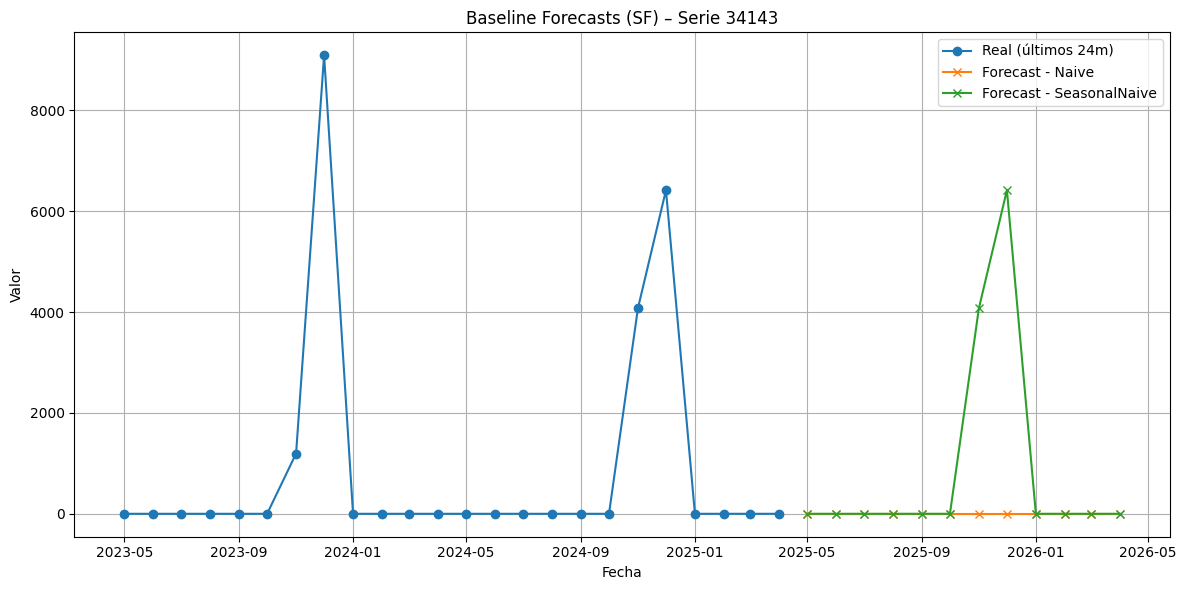

In [44]:
# --- Baselines Naïve con statsforecast sobre una sola serie ---

import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

SERIE_ID = "34143"   # <- ahora string
HORIZON  = 12
FREQ     = 'MS'
SP       = HORIZON        # estacionalidad anual en mensual

# filtra la serie
df_real = df[df['unique_id'] == SERIE_ID].copy()
assert not df_real.empty, f"No hay datos para unique_id={SERIE_ID}"

# configura y pronostica
sf = StatsForecast(models=[Naive(), SeasonalNaive(season_length=SP)], freq=FREQ, n_jobs=1)
fcst = sf.forecast(h=HORIZON, df=df)
fcst_s = fcst[fcst['unique_id'] == SERIE_ID].copy()

# columnas de modelos devueltas por statsforecast
model_cols = [c for c in fcst_s.columns if c not in ('unique_id','ds')]
print("Modelos devueltos:", model_cols)

# plot: últimos 24 meses reales + 12 meses de forecast
plt.figure(figsize=(12,6))
tail_n = 24
plt.plot(df_real['ds'].tail(tail_n), df_real['y'].tail(tail_n), label='Real (últimos 24m)', marker='o')

for m in model_cols:
    plt.plot(fcst_s['ds'], fcst_s[m], label=f'Forecast - {m}', marker='x')

plt.title(f'Baseline Forecasts (SF) – Serie {SERIE_ID}')
plt.xlabel('Fecha'); plt.ylabel('Valor')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [1]:
# --- Parámetros ---
DF_NAME   = 'df_Noel_LTS_h12'
SERIE_ID  = "34143"    # ahora string (hemos estandarizado unique_id a str)
H         = 12         # horizonte de test (y forecast)
FREQ      = 'W'
SP        = 12         # estacionalidad mensual para SeasonalNaive
TAIL_PLOT = 36         # meses de histórico a mostrar en la gráfica

# --- 1) Selección y sanity check ---
df = globals()[DF_NAME].copy()
assert {'unique_id','ds','y'}.issubset(df.columns)
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(['unique_id','ds']).reset_index(drop=True)

s = df[df['unique_id'] == SERIE_ID].copy()
assert len(s) >= 3*H, f"La serie {SERIE_ID} tiene {len(s)} puntos; se recomienda ≥ {3*H} para estabilidad."

# --- 2) Split temporal: último H como test ---
train = s.iloc[:-H].copy()
test  = s.iloc[-H:].copy()        # los últimos H meses reales

# --- 3) Ajuste y forecast SOLO con el train ---
sf = StatsForecast(
    models=[Naive(), SeasonalNaive(season_length=SP)],
    freq=FREQ,
    n_jobs=1
)
fcst = sf.forecast(h=H, df=train)  # importante: entrenamos con 'train', no con toda la serie
fcst_s = fcst[fcst['unique_id'] == SERIE_ID].copy()

# --- 4) Alinear y preparar para comparar ---
# Columnas devueltas por statsforecast (una por modelo)
model_cols = [c for c in fcst_s.columns if c not in ('unique_id','ds')]
# Join con test por 'ds' (ds de forecast debe coincidir con ds de test)
cmp = test[['ds','y']].merge(fcst_s[['ds'] + model_cols], on='ds', how='left')

# --- 5) Métricas rápidas (MAE por modelo) ---
def mae(y_true, y_pred): 
    return float(np.mean(np.abs(y_true - y_pred)))

metrics = {
    m: mae(cmp['y'].values, cmp[m].values) 
    for m in model_cols
}
print("MAE en test (últimos H meses):")
for m, v in metrics.items():
    print(f"  {m:>15s}: {v:,.3f}")

# --- 6) Gráfico: train (cola), test y forecast ---
plt.figure(figsize=(12,6))
# histórico reciente
plt.plot(train['ds'].tail(TAIL_PLOT), train['y'].tail(TAIL_PLOT), label='Train (cola)', marker='o')
# test real
plt.plot(test['ds'], test['y'], label='Test (real)', marker='o')

# forecasts por modelo
for m in model_cols:
    plt.plot(fcst_s['ds'], fcst_s[m], label=f'Forecast - {m}', marker='x')

plt.title(f'Baselines SF – Backtest correcto (h={H}) – Serie {SERIE_ID}')
plt.xlabel('Fecha'); plt.ylabel('Valor')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


KeyError: 'df_Noel_LTS_h12'

---
PASO 3 - Añadir Drift y MovingAverage con sktime usando el mismo split train/test

¿Qué? Predecir con Drift y MovingAverage (no están en statsforecast) sobre la misma serie 34143, usando solo train y comparando contra test (últimos h meses).

¿Por qué? Cerrar el set de baselines Naïve de referencia y tener una base justa para comparar más adelante con Croston/ETS/etc.
---

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sktime baselines
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split


MAE en test (últimos H meses) – sktime:
        SKT_DRIFT: 3,632.616
    SKT_MOVAVG_w3: 874.667


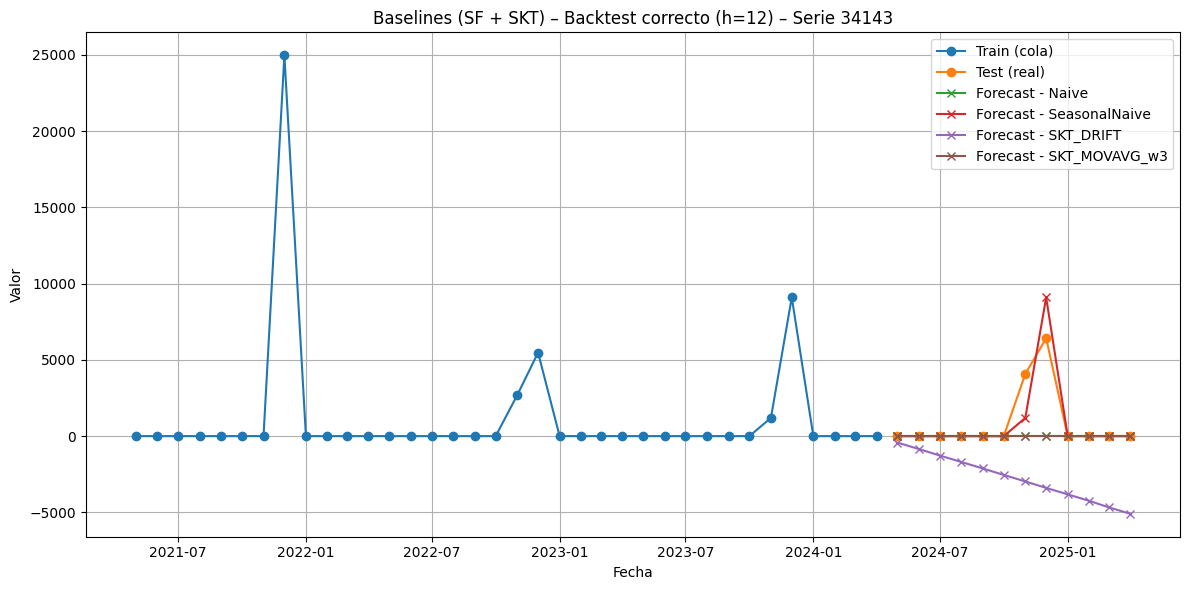

In [47]:
# Reutilizamos 's', 'train', 'test', 'H' del paso anterior
# s: dataframe de la serie SERIE_ID con columnas ['unique_id','ds','y']
# train/test: split temporal con test = últimos H pasos

# 1) Convertir a formato sktime (Series con índice DatetimeIndex)
y_all   = s.set_index('ds')['y'].asfreq('MS')  # mensual inicio de mes
y_train = train.set_index('ds')['y'].asfreq('MS')
y_test  = test.set_index('ds')['y'].asfreq('MS')

# 2) Definir modelos sktime
#   - Drift: tendencia lineal entre el primer y último valor del train
#   - MovingAverage: media móvil; window_length parametrizable
W = 3  # puedes probar 3, 6, 12
if len(y_train) < W:
    raise ValueError(f"El train tiene {len(y_train)} puntos; debe ser >= W ({W}) para moving average.")

models_skt = {
    'SKT_DRIFT'       : NaiveForecaster(strategy='drift'),
    f'SKT_MOVAVG_w{W}': NaiveForecaster(strategy='mean', window_length=W),
}

# 3) Ajuste y predicción
preds_skt = {}
for name, forecaster in models_skt.items():
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh=np.arange(1, H+1))  # H pasos adelante
    preds_skt[name] = y_pred

# 4) Construir DataFrame de comparación (mismo esquema que SF)
cmp_skt = y_test.to_frame('y').copy()
for name, ser in preds_skt.items():
    cmp_skt[name] = ser.values

# 5) Métricas rápidas (MAE) y plot conjunto
def mae(y_true, y_pred): 
    return float(np.mean(np.abs(y_true - y_pred)))

print("\nMAE en test (últimos H meses) – sktime:")
for name in preds_skt:
    print(f"  {name:>15s}: {mae(cmp_skt['y'].values, cmp_skt[name].values):,.3f}")

# 6) Gráfica: añadimos SKT al gráfico anterior
plt.figure(figsize=(12,6))
# histórico reciente
plt.plot(y_train.tail(36).index, y_train.tail(36).values, label='Train (cola)', marker='o')
# test real
plt.plot(y_test.index, y_test.values, label='Test (real)', marker='o')

# forecasts SF (reutilizamos fcst_s de antes)
for m in [c for c in fcst_s.columns if c not in ('unique_id','ds')]:
    plt.plot(fcst_s['ds'], fcst_s[m], label=f'Forecast - {m}', marker='x')

# forecasts SKT
for name, ser in preds_skt.items():
    plt.plot(ser.index, ser.values, label=f'Forecast - {name}', marker='x')

plt.title(f'Baselines (SF + SKT) – Backtest correcto (h={H}) – Serie {SERIE_ID}')
plt.xlabel('Fecha'); plt.ylabel('Valor')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


1️⃣ Qué representan esos números
MAE (Mean Absolute Error) = error absoluto medio entre las predicciones y los valores reales en el periodo de test (últimos H = 12 meses).

SKT_DRIFT = Naïve con deriva (strategy='drift' en sktime). Este modelo asume que la tendencia observada entre el primer y último valor del train seguirá igual en el futuro.

Como tu serie tiene picos aislados y muchos ceros, la deriva intenta prolongar un “pendiente” basada en esos picos → acaba prediciendo valores negativos o muy alejados de la realidad, lo que dispara el MAE (3 632).

SKT_MOVAVG_w3 = media móvil simple de los últimos 3 pasos (strategy='mean', window_length=3). Este suaviza mucho y produce valores constantes (promedio de los últimos 3 del train).

En series con muchos ceros y picos, tiende a “ignorar” los picos si están lejos en el tiempo → menor error que drift (874), aunque sigue sin ser perfecto.

---

2️⃣ Interpretación visual del gráfico
El bloque Train (cola) muestra los últimos 36 meses de entrenamiento.

El bloque Test (real) son los 12 meses que no vio el modelo.

Naive y SeasonalNaive de StatsForecast hacen predicciones simples (último valor o último valor de la misma época del año anterior).

SKT_DRIFT dibuja una línea decreciente en el test (porque el último valor del train era 0 y el primero del train tenía un valor alto → pendiente negativa).

SKT_MOVAVG_w3 predice constante ≈ media de los últimos 3 puntos del train.

---

3️⃣ Por qué el MAE de drift es tan alto
Tu serie 34143 tiene estructura “demanda intermitente”: muchos ceros + picos grandes.

Si el pico grande está cerca del final del train, la pendiente calculada por drift puede ser enorme, y si además el último punto del train es 0, la extrapolación baja rápidamente → valores negativos muy lejanos de la realidad.

Esto hace que el MAE suba mucho.

---
SIGUIENTE PASO:

Ahora añadimos Croston y Variantes (statsforecast) usando el mismo split train/test y, además, dejamos la estructura tabular de métricas que luego reutilizaremos cuando iteremos por muchas series/modelos.

NOTA: En este paso se integra statsforecast (Croston, SBA, SBJ, TSB). En el siguiente se añadirá la parte de pyInterDemand con el mismo naming (PID_*) y se acopla a las mismas tablas.

In [48]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, CrostonSBA, TSB

In [49]:
# Se reutilizan variables del paso anterior:
# df (preprocesado), SERIE_ID (str), H (horizonte = 12), FREQ = 'MS', train, test ya creados
alpha_d = 0.3
alpha_p = 0.3
# ========= 1) Entrenar SOLO con train y predecir H pasos =========
sf_croston = StatsForecast(models = [CrostonClassic(),     # Croston 1972
                                     CrostonOptimized(),   # Croston con alpha opt.
                                     CrostonSBA(),         # Syntetos-Boylan Approx.
                                     TSB(alpha_d, alpha_p) # Teunter-Syntetos-Babai
                                     ],
                                     freq = FREQ,
                                     n_jobs = 1
                           )

fcst_cros = sf_croston.forecast(h = H, df = train)
fcst_cros = fcst_cros[fcst_cros['unique_id'] == SERIE_ID].copy()

# Renombrado claro por librería (para tabular sin ambigüedad)
rename_map = {'CrostonClassic':   'SF_CROSTON',
              'CrostonOptimized': 'SF_CROSTON_OPT',
              'CrostonSBA':       'SF_CROSTON_SBA',
              'TSB':              'SF_TSB',
              }

fcst_cros = fcst_cros.rename(columns = rename_map)

In [56]:
# ========= 2) Armar matriz de comparación (alineada por fecha) =========
# test: y real (últimos H)
comp_sf = test[['ds', 'y']].merge(
    fcst_cros[['ds'] + list(rename_map.values())], 
    on = 'ds', 
    how = 'left')

In [ ]:
# from numpy import array
# from permetrics.regression import RegressionMetric

# ## For 1-D array
# y_true = array([3, -0.5, 2, 7])
# y_pred = array([2.5, 0.0, 2, 8])

# evaluator = RegressionMetric(y_true, y_pred)
# print(evaluator.mean_absolute_error())

# ## For > 1-D array
# y_true = array([[0.5, 1], [-1, 1], [7, -6]])
# y_pred = array([[0, 2], [-1, 2], [8, -5]])

# evaluator = RegressionMetric(y_true, y_pred)
# print(evaluator.MAE(multi_output="raw_values"))

In [51]:
# ========= 3) Métricas y estructura tabular (para este horizonte y serie) =========
# Definición de métricas base (Ampliar con métricas deseadas)
# MAE - Mean Absolute Error
def mae(y, yhat): return float(np.mean(np.abs(yhat - y)))

def smape(y, yhat):
    denom = (np.abs(y) + np.abs(yhat))
    out = np.where(denom == 0, 0.0, 200.0 * np.abs(yhat - y) / denom)
    return float(np.mean(out))

y_true = comp_sf['y'].values
model_cols = [c for c in comp_sf.columns if c not in ('ds', 'y')]

In [57]:
# === 3.b) Construir metrics_overall y metrics_by_step desde comp_sf ===
# comp_sf: columnas ['ds', 'y', 'SF_CROSTON', 'SF_CROSTON_OPT', 'SF_CROSTON_SBA', 'SF_TSB', ...]
assert 'y' in comp_sf.columns, "comp_sf debe contener la columna 'y'"
model_cols = [c for c in comp_sf.columns if c not in ('ds', 'y')]
assert len(model_cols) > 0, "No hay columnas de modelos en comp_sf"

# Métricas
def mae(y, yhat): 
    return float(np.mean(np.abs(yhat - y)))

def smape(y, yhat):
    denom = (np.abs(y) + np.abs(yhat))
    out = np.where(denom == 0, 0.0, 200.0 * np.abs(yhat - y) / denom)
    return float(np.mean(out))

y_true = comp_sf['y'].to_numpy(dtype=float)
H = len(y_true)  # por si no lo tienes definido arriba

metrics_overall_rows = []
metrics_by_step_rows = []

for m in model_cols:
    y_hat = comp_sf[m].to_numpy(dtype=float)
    # Seguridad: deben tener mismo largo
    if len(y_hat) != H:
        raise ValueError(f"Modelo {m}: longitud predicción {len(y_hat)} != H={H}")

    # --- Overall (promedio en el horizonte) ---
    metrics_overall_rows.append({'model': m, 'metric': 'MAE',   'value': mae(y_true, y_hat)})
    metrics_overall_rows.append({'model': m, 'metric': 'sMAPE', 'value': smape(y_true, y_hat)})

    # --- Por paso del horizonte (guardamos valores atómicos; agregaciones se harán después) ---
    abs_err = np.abs(y_true - y_hat)
    smape_t = np.where((np.abs(y_true)+np.abs(y_hat))==0, 0.0,
                       200.0*np.abs(y_true - y_hat)/(np.abs(y_true)+np.abs(y_hat)))
    for t in range(1, H+1):
        # En una sola serie, mean == valor; ponemos ambos para que la tabla ancha los formatee igual que cuando agregues muchas series
        metrics_by_step_rows.append({'model': m, 'h_step': t, 'metric': 'MAE',   'agg': 'mean', 'value': float(abs_err[t-1])})
        metrics_by_step_rows.append({'model': m, 'h_step': t, 'metric': 'MAE',   'agg': 'sum',  'value': float(abs_err[t-1])})
        metrics_by_step_rows.append({'model': m, 'h_step': t, 'metric': 'sMAPE', 'agg': 'mean', 'value': float(smape_t[t-1])})
        metrics_by_step_rows.append({'model': m, 'h_step': t, 'metric': 'sMAPE', 'agg': 'sum',  'value': float(smape_t[t-1])})

# DataFrames “largos” requeridos por tus utilidades
metrics_overall = pd.DataFrame(metrics_overall_rows)   # columnas: ['model','metric','value']
metrics_by_step = pd.DataFrame(metrics_by_step_rows)   # columnas: ['model','h_step','metric','agg','value']


In [58]:
# TABLAS (CÓDIGO UTILITARIO)
def build_overall_table(metrics_overall: pd.DataFrame) -> pd.DataFrame:
    """
    Tabla General:
        filas = modelos
        columnas = cada métrica (promedio del horizonte)
        Columnas esperadas: ['model', 'metric', 'value'] en metrics_overall.
    """
    req = {'model', 'metric', 'value'}
    if not req.issubset(metrics_overall.columns):
        raise ValueError(f'metrics_overall debe contener {req}')
    tbl = metrics_overall.pivot(index = 'model', columns = 'metric', values = 'value')
    return tbl.reset_index()

def _detect_step_col(df: pd.DataFrame) -> str:
    if 'h_step' in df.columns: return 'h_step'
    if 'h_steps' in df.columns: return 'h_steps'
    raise ValueError("No se encontró la columna de paso ('h_step' o 'h_steps').")

def build_step_tables(metrics_by_step: pd.DataFrame,
                      H: int,
                      metrics: list[str] | None = None,
                      aggs: tuple[str, ...] = ('mean','sum')
                      ) -> dict[str, pd.DataFrame]:
    """
    Devuelve un dict de tablas anchas por combinación (métrica, agg).
    Claves del dict: f"{metric}_{agg}".
    Columnas: {metric}_1_{agg} ... {metric}_{H}_{agg}; filas=model.

    Espera columnas en metrics_by_step:
      - 'model'
      - 'h_step' o 'h_steps'
      - 'metric' (p.ej. 'MAE', 'sMAPE', ...)
      - 'agg'    (p.ej. 'mean', 'sum')
      - 'value'
    """
    df = metrics_by_step.copy()

    # detectar columna de paso
    if 'h_step' in df.columns:
        step_col = 'h_step'
    elif 'h_steps' in df.columns:
        step_col = 'h_steps'
    else:
        raise ValueError("No se encontró la columna de paso ('h_step' o 'h_steps').")

    # limitar a métricas y aggs presentes (si se especifican)
    metrics_present = sorted(df['metric'].unique().tolist())
    if metrics is None:
        metrics = metrics_present
    else:
        metrics = [m for m in metrics if m in metrics_present]

    aggs_present = sorted(df['agg'].unique().tolist())
    aggs = tuple(a for a in aggs if a in aggs_present)

    out = {}
    for m in metrics:
        for a in aggs:
            sub = df[(df['metric'] == m) & (df['agg'] == a)][['model', step_col, 'value']]
            wide = sub.pivot(index='model', columns=step_col, values='value')

            # --- OPCIONAL: asegurar columnas 1..H en orden, rellenando faltantes con NaN ---
            # wide = wide.reindex(columns=range(1, H+1))

            # renombrar columnas con el patrón {metric}_{k}_{agg}
            wide.columns = [f"{m}_{int(k)}_{a}" for k in wide.columns]
            out[f"{m}_{a}"] = wide.reset_index()

    return out
    # Con esta última función se obtiene solo las tablas necesarias: una por cada combinación métrica x agregación
    # presente en metrics_by_step, sin columnas extra de paso/métrica/agg.
    # Si en algún momento se quiere forzar que siempre existan las columnas de 1...H, descomentar la línea de reindex.

In [59]:
# USO CON TABLAS ACTUALES
# metrics_overall: ['model', 'metric', 'value']
# metrics_by_step: ['model', 'h_step' (o 'h_steps'), 'metric', 'agg', 'value']
# H = 12 (o 3/6 según el caso)
tabla_general = build_overall_table(metrics_overall)
tablas_por_metric = build_step_tables(
    metrics_by_step = metrics_by_step,
    H = H,
    metrics = None,        # o lista específica p.ej. ['MAE', 'sMAPE']
    aggs = ('mean', 'sum') # creará una tabla por combinación métrica-agg
)

# Ejemplos de acceso:
# tablas_por_metric['MAE_mean']   -> TABLA PROMEDIO x PASO (MAE)
# tablas_por_metric['MAE_sum']    -> TABLA SUMA x PASO (MAE)
# tablas_por_metric['sMAPE_mean'] -> TABLA PROMEDIO x PASO (sMAPE)
# tablas_por_metric['sMAPE_sum']  -> TABLA SUMA x PASO (sMAPE)

# Vista rápida
print('Tabla Gneral (Promedio en el Horizonte):')
display(tabla_general)

for key, df_tab in tablas_por_metric.items():
    print(f'\nTabla {key} (ancha, una columna por paso):')
    display(df_tab)

# Con esto, si en el futuro se evalúan más métricas, 
# se obtendrá 1 tabla general y tantas tablas 
# como cominbaciones de métrica x dimensión.

# Ninguna tabla incluye columnas de paso/métrica/agg;
# únicamente model y las columnas anchas {METRICA}_{k}_{agg}.

Tabla Gneral (Promedio en el Horizonte):


metric,model,MAE,sMAPE
0,SF_CROSTON,3355.875703,171.858628
1,SF_CROSTON_OPT,1932.657502,184.052882
2,SF_CROSTON_SBA,3231.815277,172.679024
3,SF_TSB,1572.789049,188.512747



Tabla MAE_mean (ancha, una columna por paso):


,model,MAE_1_mean,MAE_2_mean,MAE_3_mean,MAE_4_mean,MAE_5_mean,MAE_6_mean,MAE_7_mean,MAE_8_mean,MAE_9_mean,MAE_10_mean,MAE_11_mean,MAE_12_mean
0,SF_CROSTON,3721.812754,3721.812754,3721.812754,3721.812754,3721.812754,3721.812754,355.187246,2697.193649,3721.812754,3721.812754,3721.812754,3721.812754
1,SF_CROSTON_OPT,1586.985453,1586.985453,1586.985453,1586.985453,1586.985453,1586.985453,2490.014547,4832.020949,1586.985453,1586.985453,1586.985453,1586.985453
2,SF_CROSTON_SBA,3535.722116,3535.722116,3535.722116,3535.722116,3535.722116,3535.722116,541.277884,2883.284287,3535.722116,3535.722116,3535.722116,3535.722116
3,SF_TSB,1047.182774,1047.182774,1047.182774,1047.182774,1047.182774,1047.182774,3029.817226,5371.823629,1047.182774,1047.182774,1047.182774,1047.182774



Tabla MAE_sum (ancha, una columna por paso):


,model,MAE_1_sum,MAE_2_sum,MAE_3_sum,MAE_4_sum,MAE_5_sum,MAE_6_sum,MAE_7_sum,MAE_8_sum,MAE_9_sum,MAE_10_sum,MAE_11_sum,MAE_12_sum
0,SF_CROSTON,3721.812754,3721.812754,3721.812754,3721.812754,3721.812754,3721.812754,355.187246,2697.193649,3721.812754,3721.812754,3721.812754,3721.812754
1,SF_CROSTON_OPT,1586.985453,1586.985453,1586.985453,1586.985453,1586.985453,1586.985453,2490.014547,4832.020949,1586.985453,1586.985453,1586.985453,1586.985453
2,SF_CROSTON_SBA,3535.722116,3535.722116,3535.722116,3535.722116,3535.722116,3535.722116,541.277884,2883.284287,3535.722116,3535.722116,3535.722116,3535.722116
3,SF_TSB,1047.182774,1047.182774,1047.182774,1047.182774,1047.182774,1047.182774,3029.817226,5371.823629,1047.182774,1047.182774,1047.182774,1047.182774



Tabla sMAPE_mean (ancha, una columna por paso):


,model,sMAPE_1_mean,sMAPE_2_mean,sMAPE_3_mean,sMAPE_4_mean,sMAPE_5_mean,sMAPE_6_mean,sMAPE_7_mean,sMAPE_8_mean,sMAPE_9_mean,sMAPE_10_mean,sMAPE_11_mean,sMAPE_12_mean
0,SF_CROSTON,200.0,200.0,200.0,200.0,200.0,200.0,9.108752,53.194788,200.0,200.0,200.0,200.0
1,SF_CROSTON_OPT,200.0,200.0,200.0,200.0,200.0,200.0,87.924468,120.710114,200.0,200.0,200.0,200.0
2,SF_CROSTON_SBA,200.0,200.0,200.0,200.0,200.0,200.0,14.220351,57.927934,200.0,200.0,200.0,200.0
3,SF_TSB,200.0,200.0,200.0,200.0,200.0,200.0,118.255627,143.897335,200.0,200.0,200.0,200.0



Tabla sMAPE_sum (ancha, una columna por paso):


,model,sMAPE_1_sum,sMAPE_2_sum,sMAPE_3_sum,sMAPE_4_sum,sMAPE_5_sum,sMAPE_6_sum,sMAPE_7_sum,sMAPE_8_sum,sMAPE_9_sum,sMAPE_10_sum,sMAPE_11_sum,sMAPE_12_sum
0,SF_CROSTON,200.0,200.0,200.0,200.0,200.0,200.0,9.108752,53.194788,200.0,200.0,200.0,200.0
1,SF_CROSTON_OPT,200.0,200.0,200.0,200.0,200.0,200.0,87.924468,120.710114,200.0,200.0,200.0,200.0
2,SF_CROSTON_SBA,200.0,200.0,200.0,200.0,200.0,200.0,14.220351,57.927934,200.0,200.0,200.0,200.0
3,SF_TSB,200.0,200.0,200.0,200.0,200.0,200.0,118.255627,143.897335,200.0,200.0,200.0,200.0


---
GUARDADO DE RESULTADOS

---

La función `save_results`:
- Recibe:
    - `metrics_overall` (DataFrame global)
    - `metrics_by_step` (DataFrame largo por paso)
    - `tables_dict` (diccionario {nombre_tabla: DataFrame} de `build_step_tables`)
    - `output_dir` (ej. `'results/h12'`)
- Crea la carpeta si no existe.
- Guarda cada DataFrame en `.xlsx` usando `pandas.DataFrame.to_excel`.

In [60]:
import os
import re
import pandas as pd

def collect_dfs_from_globals(glob: dict, only_h: tuple[int, ...] = (3,6,12)) -> dict[str, pd.DataFrame]:
    """
    Devuelve {df_name: df} para todas las variables en globals() que:
      - sean DataFrame,
      - y cuyo nombre cumpla: df_{Cliente}_{(ITS|LTS|STS|ETS)}_h{H}, con H en only_h.
    """
    pat = re.compile(rf"^df_[^_]+_(ITS|LTS|STS|ETS)_h({'|'.join(map(str, only_h))})$")
    out = {}
    for name, obj in glob.items():
        if isinstance(obj, pd.DataFrame) and pat.match(name):
            out[name] = obj
    return out

# Uso: recoge automáticamente el/los df activos en tu sesión
dfs_dict = collect_dfs_from_globals(globals())

print("DataFrames detectados:")
for k in dfs_dict:
    print(" -", k)


def infer_context_from_df_name(df_name: str) -> tuple[str, str, int]:
    """
    Extrae (cliente, demanda, H) de un nombre de df con patrón:
        df_{cliente}_{demanda}_h{H}
    Ej: 'df_Noel_LTS_h12' -> ('Noel', 'LTS', 12)
    """
    m = re.match(r'^df_([^_]+)_([^_]+)_h(\d+)$', df_name)
    if not m:
        raise ValueError(f"Nombre de dataframe inválido: '{df_name}'."
                         "Esperado: df_{cliente}_{demanda}_h{H} (p.ej. df_Noel_LTS_h12)"
        )
    cliente, demanda, H_str = m.groups()
    return cliente, demanda, int(H_str)


def save_results(df_name: str,
                 metrics_overall: pd.DataFrame,
                 metrics_by_step: pd.DataFrame,
                 tables_dict: dict[str, pd.DataFrame],
                 base_dir: str = "results_backtesting") -> None:
    """
    Guarda las métricas y tablas de resultados en formato .xlsx.
    Guarda resultados en .xlsx usando cliente/demanda/H inferidos del nombre del df.
    Crea subcarpeta: {cliente}_{demanda}_h{H}

    Parametros:
    -----------
    metrics_overall: pd.DataFrame
        Métricas Globales (promedio sobre el horizonte completo).
    metrics_by_step: pd.DataFrame
        Métricas por paso del horizonte (formato largo).
    tables_dict: dict
        Diccionario {nombre_tabla: DataFrame} generado por build_step_tables().
    base_dir: str
        Carpeta de destino, por ejemplo "results".
    H: int
        Horizonte (3, 6, 12, etc.).
    """

    # Crear carpeta base y subcarpetas
    cliente, demanda, H = infer_context_from_df_name(df_name)
    subfolder = f"{cliente}_{demanda}_h{H}"
    output_dir = os.path.join(base_dir, subfolder)
    os.makedirs(output_dir, exist_ok=True)

    # archivos principales
    # Guardar métricas globales
    file_overall  = f"{cliente}_{demanda}_h{H}_metrics_overall.xlsx"
    metrics_overall.to_excel(os.path.join(output_dir, file_overall), index=False)
    
    # Guardar métricas por paso
    file_by_step  = f"{cliente}_{demanda}_h{H}_metrics_by_step.xlsx"
    metrics_by_step.to_excel(os.path.join(output_dir, file_by_step), index=False)

    # Guardar tablas pivotadas por métrica/agg
    for name, df_tab in tables_dict.items():
        file_table = f"{cliente}_{demanda}_h{H}_step_table_{name}.xlsx"
        df_tab.to_excel(os.path.join(output_dir, file_table), index=True)

    print(f"Resultados guardados en: {os.path.abspath(output_dir)}")

    # Ventajas del enfoque:
    # - Evitar problemas de delimitadores (cada dato va en su celda)
    # - Compatible con caulquier sistema operativo y configuración regional.
    # - Los nombres de archivos se generan automáticamente a partir de tables_dict.

# ======= EJECUCIÓN DENTRO DEL LOOP =======
# base_dir será común para todos los horizontes (ej: "results_backtesting")

# Si hoy solo trabajas con uno, puedes tomarlo así:
DF_NAME, df = next(iter(dfs_dict.items()))
print("Usando:", DF_NAME)

save_results(
    df_name = DF_NAME,
    metrics_overall = tabla_general,
    metrics_by_step = metrics_by_step,
    tables_dict = tablas_por_metric,
    base_dir = "results_backtesting"
)

# Así, cada horizonte tendrá su propia carpeta dentro de results_backtesting.
# Guarda:
# - metrics_overall.xlsx -> métricas promedio por modelo para todo el horizonte.
# - metrics_by_step.xlsx -> métricas en formato largo por paso.
# - Una tabla xlsx por cada combinación métrica-agg, ya con columnas por paso y filas por modelo.


DataFrames detectados:
 - df_Noel_ITS_h3
 - df_Noel_ITS_h6
 - df_Noel_ITS_h12
 - df_Noel_LTS_h3
 - df_Noel_LTS_h6
 - df_Noel_LTS_h12
 - df_Varma_ITS_h3
 - df_Varma_ITS_h6
 - df_Varma_LTS_h3
 - df_Varma_LTS_h6
Usando: df_Noel_ITS_h3
Resultados guardados en: c:\Projects\MLForecast\scripts\results_backtesting\Noel_ITS_h3


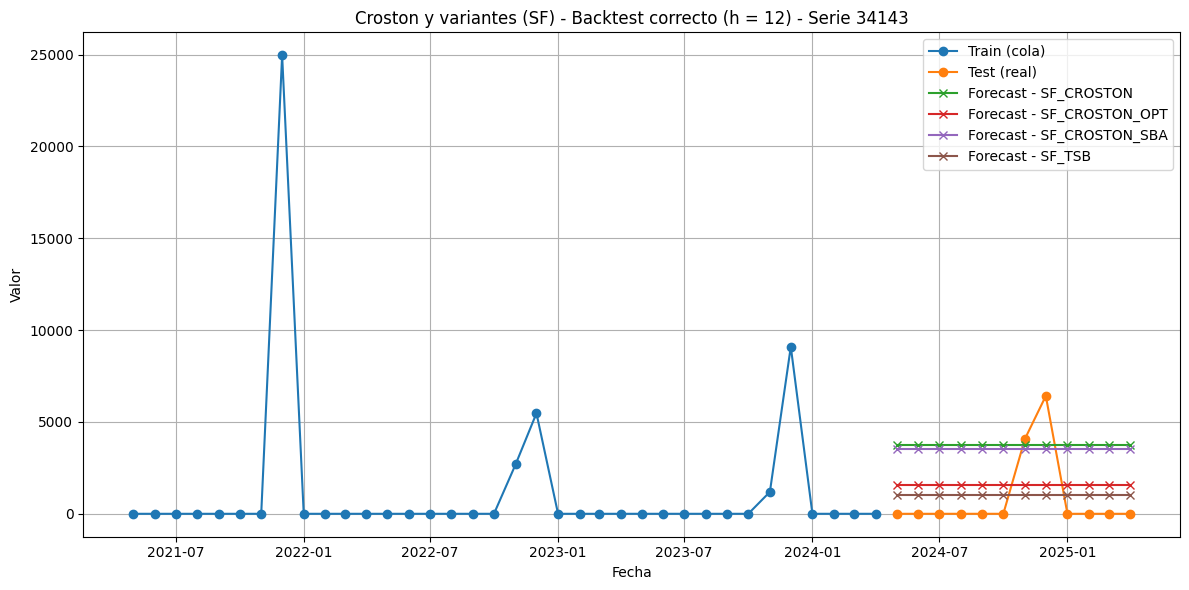

In [61]:
# ========= 4) Gráfico (opcional) =========
plt.figure(figsize = (12, 6))
plt.plot(train['ds'].tail(36), train['y'].tail(36), label = 'Train (cola)', marker = 'o')
plt.plot(test['ds'], test['y'], label = 'Test (real)', marker = 'o')

for m in model_cols:
    plt.plot(comp_sf['ds'], comp_sf[m], label = f'Forecast - {m}', marker = 'x')

plt.title(f'Croston y variantes (SF) - Backtest correcto (h = {H}) - Serie {SERIE_ID}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Esto me deja listo:
# - Predicciones sin fuga (solo con train).
# - Naming inequívoco por librería (SF_CROSTON_SBA, etc.).
# - Tres tablas ya con la estructura que luego agregaremos cuando corramos por muchas series:
#    1. metrics_overall: 1 valor por métrica y modelo (promedio en el horizonte).
#    2. metrics_by_step (agg = 'mean'): valor por paso (en 1 serie es el valor; al agregar será el promedio por paso).
#    3. metrics_by_step (agg = 'sum'): misma estructura para acumulados por paso (servirá cuando agreguemos entre series).

# SIGUIENTE PASO:
# Integrar pyInterDemand con el mismo patrón (train/test), dejando nombres como:
# - PID_CROSTON, PID_SBA, PID_SBJ, PID_TSB, PID_ADIDA, etc.
# ¿Instalamos y lo añadimos ya (pip install pyInterDemand) y te paso el bloque equivalente PID_* que vuelca métricas a las mismas tablas?

---
ORQUESTADOR BACKTESTING

---

Se presenta el esqueleto documentado del orquestador para un único DatFrame df_{Cliente}_{Demanda}_h{H}. No ejecuta modelos todavía: solo define el flujo y los puntos de enganche (TODO) para ir rellenando en micro-pasos.

El flujo dentro del orquestador (para un solo dataframe):
1. **Extraer metadatos** (cliente, tipo de demanda y horizonte) del nombre del df (`DF_NAME`).
2. **Preparar train/test** en función del horizonte `H` y la estrategia de split que toque para el tipo de modelo.
3. **Entrenar modelos baseline** (Naïve, Seasonal Naïve, Croston, etc. usando StatsForecast, PyInterDemand, Sktime).
4. **Obtener predicciones** (`y_pred`) y valores reales (`y_true`) para ese horizonte.
5. **Calcular métricas**:
    - Globales en todo el horizonte (tabla general).
    - Por paso del horizonte, agregación `mean` y `sum` (tablas por métrica).
6. **Generar tablas anchas** con la función que ya hicimos (`build_step_tables`).
7. **Guardar resultados** en la estructura de carpetas:

results/{cliente}/{demada}/h{H}/
    metrics_overall.xlsx
    metrics_by_step.xlsx
    table_MAE_mean.xlsx
    table_MAE_sum.xlsx
    ...

8. **(Opcional)** Guardar también las predicciones y valores reales en un fichero para análisis posterior.

**VENTAJA**

Actualmente se llama una vez:

DF_NAME, df = next(iter(dfs_dict.items()))
run_backtest_for_df(DF_NAME, df)

En el futuro:

for DF_NAME, df in dfs_dict.items():
    run_backtest_for_df(DF_NAME, df)

Y así se corre todo el pipeline en **todos los dataframes** automáticamente.

In [ ]:
# from __future__ import annotations
# import re
# import os
# from typing import Dict, List, Tuple
# import pandas as pd
# import numpy as np

# # ========= Helpers que ya están / se usarán =========

# def infer_context_from_df_name(df_name: str) -> Tuple[str, str, int]:
#     """Extrae (cliente, demanda, H) de nombres tipo: df_Noel_LTS_h12."""
#     m = re.match(r"^df_([^_]+)_([^_]+)_h(\d+)$", df_name)
#     if not m:
#         raise ValueError(
#             f"Nombre inválido: '{df_name}'. Esperando: df_{'cliente}'}_{'{demanda}'}_h{'{H}'}"
#         )
#     cliente, demanda, H_str = m.groups()
#     return cliente, demanda, int(H_str)

# def build_overall_table(metrics_overall: pd.DataFrame) -> pd.DataFrame:
#     """Tabla General: filas = model, columnas = métrica (promedio en el horizonte)."""
#     req = {'model', 'metric', 'value'}
#     if not req.issubset(metrics_overall.columns):
#         raise ValueError(f'metrics_overall debe contener {req}')
#     return metrics_overall.pivot(index = 'model', columns = 'metric', values = 'value').reset_index()

# def build_step_tables(metrics_by_step: pd.DataFrame, H: int,
#                       metrics: List[str] | None = None,
#                       aggs: Tuple[str, ...] = ('mean', 'sum')) -> Dict[str, pd.DataFrame]:
#     """
#     Devuelve dict con tablas anchas por combinación (métrica, agg).
#     Clave:   f'{metric}_{agg}'.
#     Columas: {metric}_{k}_{agg} para k = 1..H.
#     Filas:   model.    
#     """
#     df = metrics_by_step.copy()
#     step_col = 'h_step' if 'h_step' in df.columns else ('h_steps' if 'h_steps' in df.columns else None)
#     if step_col is None:
#         raise ValueError("Falta columna de paso ('h_step' o 'h_steps').")
    
#     metrics_present = sorted(df['metric'].unique().tolist())
#     if metrics is None:
#         metrics = metrics_present
#     else:
#         metrics = [m for m in metrics if m in metrics_present]

#     aggs_present = sorted(df['agg'].unique().tolist())
#     agss = tuple(a for a in aggs if a in aggs_present)

#     out = {}
#     for m in metrics:
#         for a in aggs:
#             sub = df[(df['metric'] == m) & (df['agg'] == a)][['model', step_col, 'value']]
#             wide = sub.pivot(index = 'model', columns = step_col, values = 'value')
#             # reindex opcional para segurar 1...H:
#             # wide = wide.reindex(columns=range(1, H+1))
#             wide.columns = [f'{m}_{int(k)}_{a}' for k in wide.columns]
#             out[f'{m}_{a}'] = wide.reset_index()
#     return out

# def save_results_from_dfname(df_name: str,
#                              metrics_overall: pd.DataFrame,
#                              metric_by_step: pd.DataFrame,
#                              tables_dict: Dict[str, pd.DataFrame],
#                              base_dir: str = 'results_backtesting') -> None:
#     """Guarda .xlsx en base a cliente/demanda/H inferidos del nombre del df."""
#     cliente, demanda, H = infer_context_from_df_name(df_name)
#     subfolder = f'{cliente}_{demanda}_h{H}'
#     output_dir = os.path.join(base_dir, subfolder)
#     os.makedirs(output_dir, exist_ok = True)

#     metrics_overall.to_excel(os.path.join(output_dir, f'{subfolder}_metrics_overall.xlsx'), index = False)
#     metrics_by_step.to_excel(os.path.join(output_dir, f'{subfolder}_metrics_by_step.xlsx'), index = False)
#     for name, df_tab in tables_dict.items():
#         df_tab.to_excel(os.path.join(output_dir, f'{subfolder}_step_table_{name}.xlsx'), index = True)

#     print(f'[OK] Resultados guardados en: {os.path.abspath(output_dir)}')


# # ========= Orquestador (ESQUELETO) =========

# def run_backtest_for_df(DF_NAME: str, df: pd.DataFrame,
#                         metrics_list: List[str] = ('MAE', 'sMAPE'),
#                         horizon_from_name: bool = True,
#                         freq: str = 'MS') -> None:
#     """
#     Orquesta el flujo de backtesting para un DataFrame con estructura long ['unique_id', 'ds', 'y'].
    
#     Pasos:
#         1) Inferir (cliente, demanda, H) desde DF_NAME (o usar H externo si lo hubiera).
#         2) Iterar por serie (unique_id):
#             2.1) Split train/test: último H como test (holdout temporal).
#             2.2) Entrenar y predecir modelos baseline (SF y SKT; PID en paso posterior).
#             2.3) Acumular y_true / y_pred por modelo.
#             2.4) Calcular métricas globales y por paso; acumular en tablas "largas".
#         3) Agregar a nivel de DataFrame:
#             3.1) Tabla general (promedio en horizonte) por modelo.
#             3.2) Tablas por-métrica y por-agregación (mean/sum) con columnas 1..H.
#         4) Guardar resultados en .xlsx con nombres basados en DF_NAME.

#     NOTA: Este esqueleto deja marcados los TODO para ser relleandos en micro-pasos.
#     """

#     # ---- 1) Contexto: cliente/demanda/H ----
#     cliente, demanda, H = infer_context_from_df_name(DF_NAME)
#     if not horizon_from_name:
#         raise NotImplementedError('Por ahora H se toma del nombre del df.')
#     print(f'[CTX] DF={DF_NAME} | cliente={cliente} | demanda={demanda} |H={H}')

#     # Sanity
#     assert {'unique_id', 'ds', 'y'}.issubset(df.columns), 'df debe tener columnas: unique_id, ds, y'
#     df = df.copy()
#     df['ds'] = pd.to_datetime(df['ds'])
#     df = df.sort_values(['unique_id', 'ds']).reset_index(drop = True)

#     # ---- 2) Loop por serie; contenedores para acumular métricas "largas" ----
#     long_overall_rows = [] # columnas: model, metric, value (se agregará luego)
#     long_step_rows = [] # columnas: model, h_step, metric, agg, value

#     unique_ids = df['unique_id'].unique().tolist()
#     print(f'[INFO] Series a evaluar: {len(unique_ids)}')

#     for uid in unique_ids:
#         s = df[df['unique_id'] == uid].copy()
#         if len(s) < 3 * H:
#             # Regla mínima recomendada (se puede ajustar)
#             continue

#         # ---- 2.1) Split temporal: último H como test ----
#         train = s.iloc[:-H].copy()
#         test =  s.iloc[-H:].copy()

#         # ---- 2.2) ENTRENAR/PREDECIR MODELOS (TODO en micro-pasos) ----
#         # * StatsForecast baselines ya probados: Naive(), SeasonalNaive(season_length=12)
#         # * Croston y variantes SF: CrostonClassic, CrostonOptimized, CrostonSBA, TSB(alpha_d, alpha_p)
#         # * SKTime baselines: Drift, MovingAverage (mean con window_length = W)
#         # * (Próximo) pyInterDemand: PID_CROSTON, PID_SBA, PID_SBJ, PID_TSB, PID_ADIDA, ...
#         #
#         # Aquí deberías construir un dict: pred_dict = {'MODEL_NAME': pd.Series(index = test['ds'], values = preds), ...}
#         # IMPORTANTE: Todas las predicciones deben alinear en las fechas de test['ds'] (mismo fh).
#         pred_dict = {}

#         # TODO (ejemplo minúsculo orientativo, reemplazar por funciones reales):
#         # pred_dict['SF_NAIVE'] =      forecast_sf_naive(train, H, freq)
#         # pred_dict['SF_SNAIVE'] =     forecast_sf_seasonal_naive(train, H, freq, sp = 12)
#         # pred_dict['SF_CROSTON'] =    forecast_sf_croston(train, H, freq)
#         # pred_dict['SKT_DRIFT'] =     forecast_skt_drift(train, H)
#         # pred_dict['SKT_MOVAVG_W3'] = forecast_skt_movavg(train, H, window = 3)
#         # ... etc.

#         # ---- 2.3) Calcular métricas por modelo sobre test ----
#         # Define aquí las funciones de métricas que usarás:
#         def _mae(y, yhat): return float(np.mean(np.abs(y - yhat)))
        
#         def _smape(y, yhat):
#             denom = (np.abs(y) + np.abs(yhat))
#             out = np.where(denom == 0, 0.0,
#                            200 * np.abs(y - yhat) / denom)
#             return float(np.mean(out))
        
#         metric_funcs = {
#             'MAE': _mae,
#             'sMAPE': _smape,
#             # TODO: añadir MAPE, MASE, RMSE, ... cuando toque
#         }

#         y_true = test['y'].values
#         for model_name, yhat_series in pred_dict.items():
#             #Alineación por ds (por si hiciera falta)
#             yhat = pd.Series(yhat_series).reindex(test['ds']).values

#             # 2.3.1) Métrica promedio en horizonte (1 valor por métrica)
#             for mname, mfunc in metric_funcs.items():
#                 long_overall_rows.append({'model': model_name,
#                                           'metric': mname,
#                                           'value': mfunc(y_true, yhat)})
            
#             # 2.3.2) Métrica por paso (guardamos valores atómicos; agregamos luego)
#             abs_err = np.abs(y_true - y_hat)
#             smape_t = np.where((np.abs(y_true) + np.abs(yhat)) == 0, 0.0,
#                                200.0 * np.abs(y_true - yhat) / (np.abs(y_true) + np.abs(yhat)))
#             # Por cada paso t = 1...H guardamos "mean" y "sum".
#             # En 1 serie, mean == valor; al agregar hará sentido.
#             for t in range(1, H + 1):
#                 for agg in ('mean', 'sum'):
#                     long_step_rows.append({'model': '{M}', 'h_step': t, 'metric': 'MAE',   'agg':agg, 'value': float(abs_err[t-1])})
#                     long_step_rows.append({'model': '{M}', 'h_step': t, 'metric': 'sMAPE', 'agg':agg, 'value': float(smape_t[t-1])})
#                 # NOTA: '{M}' es un placeholder para mostrar estructura.
#                 #       En implementación usar model_name real.
#                 long_step_rows[-1]['model'] = model_name
#                 long_step_rows[-2]['model'] = model_name
#                 long_step_rows[-3]['model'] = model_name
#                 long_step_rows[-4]['model'] = model_name
    
#     # ---- 3) Agregación a nivel de DataFrame (todas las series) ----
#     metrics_overall_long = pd.DataFrame(long_overall_rows)
#     metrics_by_step_long = pd.DataFrame(long_step_rows)

#     # 3.1) Tabla General (promedio en el horizonte) por modelo:
#     # Si se ha acumulado varias series, aquí se podrá hacer un groupby antes de pivotar:
#     # metrics_overall_long = (metrics_overall_long.groupby(['model', 'metric'], as_index = False)['value'].mean())
#     tabla_general = build_overall_table(metrics_overall_long)

#     # 3.2. Tablas por-métrica y por-agregación
#     tablas_por_metric = build_step_tables(metrics_by_step_long, H = H,
#                                           metrics = list(metrics_list),
#                                           aggs = ('mean', 'sum'))
    
#     # ---- 4) Guardado en disco con nombres basados en DF_NAME ----
#     save_results_from_dfname(df_name = DF_NAME,
#                              metrics_overall = tabla_general,
#                              metrics_by_step = metrics_by_step_long,
#                              tables_dict = tablas_por_metric,
#                              base_dir = 'results_backtesting')
    
#     print('[DONE] Orquestador completo para', DF_NAME)


# #######################################################################

# # # EJEMPLO DE USO
# # # Auto-descubrir df activo(s) si se quiere:
# # def collect_dfs_from_globals(glob: dict, only_h = (3, 6, 12)):
# #     pat = re.compile(rf"^df_[^_]+_(ITS|LTS|STS|ETS)_h({'|'.join(map(str, only_h))})$")
# #     return {name: obj for name, obj in glob.items() if isinstance(obj, pd.DataFrame) and pat.match(name)}

# # dfs_dict = collect_dfs_from_globals(globals())
# # DF_NAME, df = next(iter(dfs_dict.items()))
# # run_backtest_for_df(DF_NAME, df)

# # El siguiente micro-paso sería rellenar uno a uno los forecast_* del bloque 2.2)
# # (Por ejemplo, primero forecast_sf_naive y forecast_sf_seasonal_naive), sustituyendo
# # el 'TODO' por llamadas reales y asegurando que pred_dict devuelve Series indexadas por ds del test.

LOGICAS DE CÁLCULO DE MÉTRICAS

LÓGICA 1
Promedio general dentro del horizonte para cada modelo de una misma serie.

Se hace el promedio con los diferentes resultados de las métricas mes a mes dentro del horizonte para cada modelo para cada serie.
Es decir, si tengo un modelo y tengo los 12 valores porque el horizonte es 12, esta métrica hace el promedio de los 12 valores de la misma métrica para ese modelo y para esa serie.

LÓGICA 2
Promedio de cada paso temporal de las diferentes series de un dataframe.
Se hace el promedio de cada mes con los valores de cada métrica para cada mes de las diferentes series.
PROMEDIO(Metrica1_mes1_serie_1, metrica1_mes1_serie2, metrica1_mes1_serie3)

LÓGICA 3
Promedio decalado X pasos (modificable) de predicho y real de la misma serie.
Se calcula la resta entre el valor predicho del segundo paso y el valor predicho del primer paso y no sé qué más.

LÓGICA 4
Promedio decalado X pasos (=) de predicho y real del mismo intervalo de todas las series del dataframe.
Se calcula la diferencia entre el valor predicho (TENGO QUE REPASARLO)

---
¡Perfecto! Vamos en dos micro‑pasos, como pediste:

primero pyInterDemand (PID_*), y luego el bloque para AutoARIMA / AutoETS / Holt‑Winters / SES / LES / HES / ADIDA.

Los dejo en dos versiones: (A) explícita/fija y (B) extensible (registrable). En ambos casos:

Reutilizan tu split train/test actual.

Devuelven pred_dict con nombres claros (PID_*, SF_*, SKT_*, etc.).

No tocan aún tu orquestador; luego lo enchufamos.

BLOQUE pyInterDemand (PID_*)
A) Versión explícita y fija

NOTA: Las rutas de import pueden variar según la versión instalada de pyInterDemand.

In [63]:
import numpy as np
import pandas as pd

# === MÉTRICAS (mismo criterio que a vienes usando) ===
def _mae(y, yhat): return float(np.mean(np.abs(y - yhat)))
def _smape(y, yhat):
    denom = (np.abs(y) + np.abs(yhat))
    out = np.where(denom == 0, 0.0,
                   200.0 * np.abs(y - yhat) / denom)
    return float (np.mean(out))

# === BLOQUE PID EXPLÍCITO/FIJO ===
def run_pid_block_explicit(train: pd.DataFrame,
                           test: pd.DataFrame,
                           H: int) -> tuple[dict, pd.DataFrame, pd.DataFrame]:
    """
    Entrena y predice modelos PID_* con el split train/test dado.
    Devuelve:
      - pred_dict: { 'PID_*': pd.Series(pred, index = test['ds']) }
      - metrics_overall_long: filas (model, metric, value)
      - metrics_by_step_long: filas (model, h_step, metric, agg, value)
    """
    # 1) Preparar vector
    y_train = train['y'].astype(float).values

    # 2) Importar modelos PID (ajusta si la instalación usa otros paths)
    # TODO import: corregir los imports según versión instalada
    try:
      from pyInterDemand.algorithm.intermittent import (croston_method as PID_Croston,
                                                            sba_method as PID_SBA,
                                                            sbj_method as PID_SBJ,
                                                            tsb_method as PID_TSB,
                                                            hes_method as PID_HES,
                                                            les_method as PID_LES,
                                                            ses_method as PID_SES)
    except Exception as e:
      raise ImportError(
         "No pude importar pyInterDemand con estos nombres."
         "Ajusta los imports (rutas/clases) según tu instalación"
      ) from e
    
    # GOOGLE COLAB DE LIBRERIA
    # https://github.com/Valdecy/pyInterDemand
    # 3) Instanciar modelos (ejemplo de hiperparámetros razonables)
    #    Si tu API difiere (funciones vs. clases), adapta las llamadas donde marcamos TODO.
    models = {'PID_Croston': PID_Croston(),
              'PID_SBA':     PID_SBA(),
              'PID_SBJ':     PID_SBJ(),
              'PID_TSB':     PID_TSB(alpha = 0.25, beta = 0),
              'PID_HES':     PID_SES(),
              'PID_LES':     PID_LES(),
              'PID_SES':     PID_SES()}
    
    # 4) Fit & Predict
    pred_dict: dict[str, pd.Series] = {}
    for name, mdl in models.items():
       # === TODO si la API es funcional (no clases), cambia a: yhat = mdl(y_train, H) ===
       if hasattr(mdl, 'fit') and hasattr(mdl, 'predict'):
          mdl.fit(y_train)
          yhat = mdl.predict(H)
       else:
          # fallback si tu objeto es un simple callable
          yhat = mdl(y_train, H)
       
       yhat = np.asarray(yhat, dtype = float)
       if yhat.shape[0] != H:
          raise ValueError(f'{name}: devolvió {len(yhat)} pasos, esperado H = {H}')
       pred_dict[name] = pd.Series(yhat, index=test['ds'])
    
    # 5) Métricas
    y_true = test['y'].astype(float).values
    metrics_overall_long = []
    metrica_by_step_long = []

    for model_name, yhat_s in pred_dict.items():
       yhat = yhat_s.values

       metrics_overall_long += [
          {'model': model_name, 'metric': 'MAE', 'value': _mae(y_true, yhat)},
          {'model': model_name, 'metric': 'sMAPE', 'value': _smape(y_true, yhat)}
       ]

       abs_err = np.abs(y_true - yhat)
       smape_t = np.where((np.abs(y_true) + np.abs(yhat)) == 0, 0.0,
                          200.0 * np.abs(y_true - yhat)/(np.abs(y_true) + np.abs(yhat)))
       
       for t in range(1, H + 1):
          metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'MAE',   'agg': 'mean', 'value': float(abs_err[t-1])})
          metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'MAE',   'agg': 'sum',  'value': float(abs_err[t-1])})
          metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'sMAPE', 'agg': 'mean', 'value': float(smape_t[t-1])})
          metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'sMAPE', 'agg': 'sum',  'value': float(smape_t[t-1])})
    
    return pred_dict, pd.DataFrame(metrics_overall_long), pd.DataFrame(metrics_by_step_long)

NameError: name 'pred_pid' is not defined

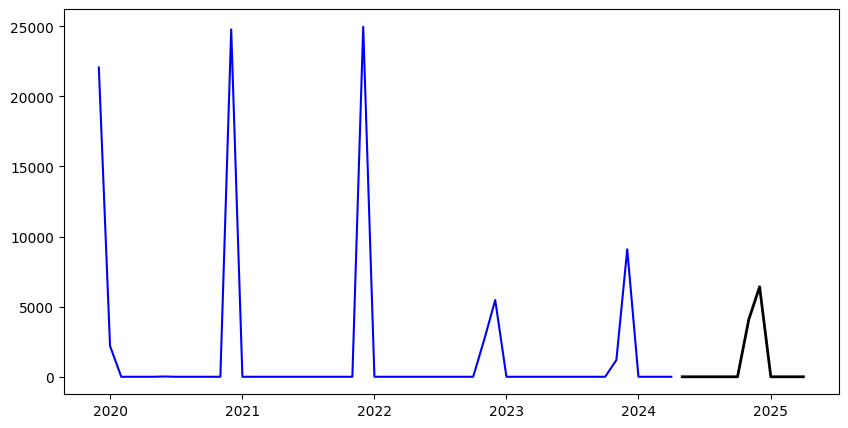

In [ ]:
# === Alinear predicciones PID al índice de test y formar comp_pid ===
comp_pid = test[['ds', 'y']].copy()

# pred_pid: dict { 'PID_*': pd.Series(pred, index = test['ds']) }
for model_name, s in pred_pid.items():
    #garantizamos el orden exacto de los ds de test
    comp_pid[model_name] = s.reindex(test['ds']).values

# columnas de modelo para el bucle de pintado
model_cols_pid = [c for c in comp_pid.columns if c not in ('ds', 'y')]


In [ ]:
# GRÁFICO CON EL MISMO ESTILO QUE ESTÁBAMOS USANDO
plt.figure(figsize = (12, 6))
plt.plot(train['ds'].tail(36), train['y'].tail(36), label = 'Train (cola)', marker = 'o')
plt.plot(test['ds'],           test['y'],           label = 'Test (real)',  marker = 'o')

for m in model_cols_pid:
    plt.plot(comp_pid['ds'], comp_pid[m], label = f'Forecast - {m}', marker = 'x')

plt.title(f'Modelos Intermitentes (PID) - Backtest (h = {H})  Serie {SERIE_ID}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Esto pinta la cola del train, el test real y, para cada PID_*, su forecast en el mismo tramo de test (sin usar datos futuros).

In [ ]:
# 4) Tablas de métricas (PID solo o unificadas con SF)
# Solo PID
tabla_general_pid = build_overall_table(metrics_overall_pid)

tablas_por_metric_pid = build_step_tables(
    metrics_by_step = metrics_by_step_pid,
    H = H,
    metrics = None, # o lista concreta, p.ej. ['MAE', 'sMAPE']
    aggs = ('mean', 'sum') # crea una tabla por métrica-agregación
)

print('Tabla General PID (Promedio en el Horizonte):')
display(tabla_general_pid)

for key, df_tab in tablas_por_metric_pid.items():
    print(f'\nTabla {key} (PID) - ancha, una columna por paso:')
    display(df_tab)

# Unificar SF + PID (Si se tienen las métricas SF)
if 'metrics_overall' in globals() and 'metrics_by_step' in globals():
    metrics_overall_all = pd.concat([metrics_overall, metrics_overall_pid], ignore_index = True)
    metrics_by_step_all = pd.concat([metrics_by_step, metrics_by_step_pid], ignore_index = True)

    tabla_general_all = build_overall_table(metrics_overall_all)
    tablas_por_metric_all = build_step_tables(
        metrics_by_step = metrics_by_step_all,
        H = H,
        metrics = None,
        aggs = ('mean', 'sum')
    )

    print('Tabla General (SF + PID):')
    display(tabla_general_all)

    for key, df_tab in tablas_por_metric_all.items():
        print(f'\nTable {key} (SF + PID) - ancha:')
        display(df_tab)

In [ ]:
# B) Versión extensible/registrable (añadir/quitar modelos rápidos)

# def run_pid_block_registry(train: pd.DataFrame, test: pd.DataFrame, H: int,
#                            registry: dict[str, callable]) -> tuple[dict, pd.DataFrame, pd.DataFrame]:
#     """
#     registry: {'PID_NOMBRE': callable(train_values: np.ndarray, H:int)-> np.ndarray}
#     """
#     y_train = train['y'].astype(float).values
#     pred_dict = {}

#     for name, forecaster_fn in registry.items():
#         yhat = np.asarray(forecaster_fn(y_train, H), dtype=float)
#         if yhat.shape[0] != H:
#             raise ValueError(f"{name}: devolvió {len(yhat)} pasos, esperado H={H}")
#         pred_dict[name] = pd.Series(yhat, index=test['ds'])

#     # métricas (igual que antes)
#     y_true = test['y'].astype(float).values
#     metrics_overall_long, metrics_by_step_long = [], []

#     for model_name, yhat_s in pred_dict.items():
#         yhat = yhat_s.values
#         metrics_overall_long += [
#             {'model': model_name, 'metric': 'MAE',   'value': _mae(y_true, yhat)},
#             {'model': model_name, 'metric': 'sMAPE', 'value': _smape(y_true, yhat)},
#         ]
#         abs_err = np.abs(y_true - yhat)
#         smape_t = np.where((np.abs(y_true)+np.abs(yhat))==0, 0.0,
#                             200.0*np.abs(y_true - yhat)/(np.abs(y_true)+np.abs(yhat)))
#         for t in range(1, H+1):
#             metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'MAE',   'agg': 'mean', 'value': float(abs_err[t-1])})
#             metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'MAE',   'agg': 'sum',  'value': float(abs_err[t-1])})
#             metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'sMAPE', 'agg': 'mean', 'value': float(smape_t[t-1])})
#             metrics_by_step_long.append({'model': model_name, 'h_step': t, 'metric': 'sMAPE', 'agg': 'sum',  'value': float(smape_t[t-1])})
#     return pred_dict, pd.DataFrame(metrics_overall_long), pd.DataFrame(metrics_by_step_long)

# # Ejemplo de construcción del registry (ajusta imports a tu instalación)
# # TODO import: corrige los paths/clases si son distintos en tu pyinterdemand
# # from pyinterdemand import CrostonSBA, TSB, SES, LES, HES, ADIDA, CrostonClassic, CrostonOptimized

# def make_registry_pid():
#     from pyinterdemand import (
#         CrostonClassic as PID_CrostonClassic,
#         CrostonOptimized as PID_CrostonOptimized,
#         CrostonSBA as PID_CrostonSBA,
#         TSB as PID_TSB,
#         SES as PID_SES,
#         LES as PID_LES,
#         HES as PID_HES,
#         ADIDA as PID_ADIDA,
#     )
#     return {
#         'PID_CROSTON_CLASSIC':  (lambda y, H: PID_CrostonClassic().fit(y).predict(H)),
#         'PID_CROSTON_OPT':      (lambda y, H: PID_CrostonOptimized().fit(y).predict(H)),
#         'PID_CROSTON_SBA':      (lambda y, H: PID_CrostonSBA().fit(y).predict(H)),
#         'PID_TSB_a03_p03':      (lambda y, H: PID_TSB(alpha_d=0.3, alpha_p=0.3).fit(y).predict(H)),
#         'PID_SES':              (lambda y, H: PID_SES().fit(y).predict(H)),
#         'PID_LES':              (lambda y, H: PID_LES().fit(y).predict(H)),
#         'PID_HES':              (lambda y, H: PID_HES().fit(y).predict(H)),
#         'PID_ADIDA':            (lambda y, H: PID_ADIDA(aggregate='auto').fit(y).predict(H)),
#     }

---
---

MICRO-PASO 2 - MODELOS ESTADÍSTICOS EXTRA (AutoARIMA, AutoETS, Holt-Winters, HES, LES, SES, ADIDA)

Aquí se mezclan librerías.
Se prepara un bloque explícito y fijo con try/except para que salte si falta algún paquete. Los nombre de modelo llevan prefijo claro.

In [ ]:
def run_stats_block_explicit(train: pd.DataFrame,
                             test: pd.DataFrame,
                             H: int,
                             freq: str = 'MS') -> tuple[dict, pd.DataFrame, pd.DataFrame]:
    """
    Modelos incluidos:
      - """